## Notebook to train an Advection-Aware AutoEncoder for a parametric 2D Linear Advection example


Consider the advection of a circular Gaussian pulse traveling in the positive $y-$direction through a rectangular domain, $\Omega = [-100,100] \times [0, 500]$ at a constant speed, $c$. The analytical solution is given by
\begin{align}\label{eq:Gaussian_pulse}
    u(x,y) = \exp{ \bigg\{ -\left(\frac{(x -x_0)^2}{2 \sigma_x^2} + \frac{(y - y_0 - ct)^2}{2 \sigma_y^2} \right) \bigg\} },
\end{align}
where $(x_0, y_0)$ is the initial location of the center of the pulse, $\sigma_x$ and $\sigma_y$ define the support of the pulse in the $x$ and $y$ directions, respectively. The domain is uniformly discretized into $100701$ computational nodes using $\Delta x = 1$ and $\Delta y = 1$.

In [1]:
## Load modules
%matplotlib inline

import numpy as np
import scipy
import os
import gc
import time
import importlib
from importlib import reload as reload


from sklearn.preprocessing import MinMaxScaler, StandardScaler, MaxAbsScaler

import tensorflow as tf
print("Tensorflow v"+str(tf.__version__))
if tf.__version__ == '1.15.0':
    tf.compat.v1.enable_eager_execution()
elif tf.__version__.split('.')[0] == 2: # in ['2.2.0','2.3.0']:
    print("Setting Keras backend datatype")
    tf.keras.backend.set_floatx('float32')
    tf.debugging.set_log_device_placement(True)

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Dense, LSTM, InputLayer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
# tf.keras.backend.set_floatx('float64')

np.random.seed(0)

import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, ScalarFormatter, FormatStrFormatter

from matplotlib import animation
matplotlib.rc('animation', html='html5')
from IPython.display import display
import matplotlib.ticker as ticker
from matplotlib import rcParams
from matplotlib.offsetbox import AnchoredText


# Plot parameters
plt.rc('font', family='serif')
plt.rcParams.update({'font.size': 20,
                     'lines.linewidth': 2,
                     'lines.markersize':10,
                     'axes.labelsize': 16, 
                     'axes.titlesize': 20,
                     'xtick.labelsize': 16,
                     'ytick.labelsize': 16,
                     'legend.fontsize': 16,
                     'axes.linewidth': 2})

import itertools
colors = itertools.cycle(['r','g','b','m','y','c'])
markers = itertools.cycle(['p','d','o','^','s','x','D','H','v','*'])

try:
    os.listdir(base_dir)
except:
    base_dir = os.getcwd()
utils_dir  = os.path.join(base_dir,'../src/utils')
nn_dir  = os.path.join(base_dir,'../src/nn_model')
work_dir = os.path.join(base_dir,'../examples')
# data_dir = os.path.join(base_dir,'../data/')
data_dir = '/gpfs/cwfs/sdutta/hfm_data/Flower/'
model_dir = '/gpfs/cwfs/sdutta/ae_data/flower/ae_models/'
# model_dir = os.path.join(base_dir,'../data/saved_models/ae_param_models/')
fig_dir  = os.path.join(base_dir,'../figures/')


os.chdir(utils_dir)
import data_utils as du
import tf_utils as tu
import plot_utils as pu
reload(pu)

os.chdir(nn_dir)
import aa_autoencoder as aa
os.chdir(work_dir)



2022-08-17 02:07:32.504068: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0


Tensorflow v2.5.1


In [2]:
device = 'gpu:0' # select gpu:# or cpu:#


# Uncomment the following when training for variable pulse size
param_list = [.5, .2, .1, ]; flag = 'sigma';  # pulse geometry as a parameter
param_train = [.1, ]; param_test = [.2, ]



In [3]:
## Load snapshot data
model ='Flower'
soln_names = ['flower']

snap_data = {}; times_offline = {}
c = {}; sigma = {}
snap_start = {}; snap_end = {}

for indx,val in enumerate(param_train):
    if flag == 'sigma':
        datafile = 'Gaussian2d_flower_500x200_c0.05_sigma'+'%.4f'%val+'.npz'
    data = np.load(os.path.join(data_dir, datafile))
    
    c[indx] = float(datafile.split('_c')[1].split('_')[0])
    sigma[indx] = float(datafile.split('_sigma')[1].split('.npz')[0])
    print("\n%d: Loading snapshots for c = %f, sigma = %f"%(indx, c[indx], sigma[indx]))
    
    snap_data[indx], times_offline[indx], nodes, Nx, Ny, snap_start[indx], snap_end[indx] = du.read_data(data, soln_names)
    
del data
gc.collect()


0: Loading snapshots for c = 0.050000, sigma = 0.100000
Loaded 200 snapshots of dimension 100000 for ['flower']  spanning times [0.000, 1.667] mins


78

In [4]:
## Prepare training snapshots

Nn = Nx * Ny

## number of steps to skip in selecting training snapshots for SVD basis
snap_incr=2
train_end_fraction = 1.0

## Subsample snapshots for building reduced basis
Nt = {}
Nt_train = {}
train_end = {}
for indx,val in enumerate(param_train):
    Nt[indx] = times_offline[indx].size
    train_end[indx] = int(Nt[indx]*train_end_fraction)
    Nt_train[indx] = times_offline[indx][:train_end[indx]+1:snap_incr].size
    print('{5}: Using {0} training snapshots for {1} = {2:.2f} in time interval [{3:.2f},{4:.2f}] mins'.format(
            Nt_train[indx], flag, param_train[indx], times_offline[indx][:train_end[indx]+1:snap_incr][0]/60, 
            times_offline[indx][:train_end[indx]+1:snap_incr][-1]/60, indx))



0: Using 100 training snapshots for sigma = 0.10 in time interval [0.00,1.66] mins


In [5]:
def set_label(key):
    if key == 'flower':
        ky = 'u'
    
    return ky

In [6]:
## Load shifted snapshots   
print("Loading high-fidelity shifted snapshots -----\n")

shifted_snap = {}
for indx,val in enumerate(param_train):
    if flag == 'sigma':
        shift_datafile = 'ShiftedGaussian2d_flower_500x200_c0.05_sigma'+'%.4f'%val+'.npz'
    
    print("\nReading data from %s"%shift_datafile)
    shift_data = np.load(os.path.join(data_dir, shift_datafile))
    shifted_snap[indx] = {}
    for key in soln_names:
        shifted_snap[indx][key] = shift_data[key].reshape((Nn,-1))

        print("%d: Loading %d shifted snapshots for c = %f, sigma = %f, key = %s"%(indx, 
                                                            shifted_snap[indx][key].shape[1], 
                                                            c[indx], sigma[indx], key))
        
del shift_data
gc.collect()


Loading high-fidelity shifted snapshots -----


Reading data from ShiftedGaussian2d_flower_500x200_c0.05_sigma0.1000.npz
0: Loading 200 shifted snapshots for c = 0.050000, sigma = 0.100000, key = flower


8

In [7]:
###  ***** Prepare Autoencoder input data *******
## 1. Concatenate parametric snapshots to prepare
##    input features for AA Autoencoder training

u = np.empty((0,Nn),)
u_shift = np.empty((0,Nn),)

for indx,val in enumerate(param_train):
    u_snap = snap_data[indx][soln_names[0]][:,:train_end[indx]+1:snap_incr].T    
    u = np.vstack((u,u_snap));
    u_shift_snap = shifted_snap[indx][soln_names[0]][:,:train_end[indx]+1:snap_incr].T
    u_shift = np.vstack((u_shift,u_shift_snap))
    

validation_data = True
skip_start = snap_incr//2
if validation_data:
    u_val = np.empty((0,Nn),)
    u_val_shift = np.empty((0,Nn),)
    for indx,val in enumerate(param_train):
        u_val_snap = snap_data[indx][soln_names[0]][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val_shift_snap = shifted_snap[indx][soln_names[0]][:,skip_start:train_end[indx]+1:snap_incr].T
        u_val = np.vstack((u_val, u_val_snap))
        u_val_shift = np.vstack((u_val_shift, u_val_shift_snap))
    

In [8]:
def data_scaler_V2(u1, u2, umax=None, umin=None, v_min=0.0, v_max=1.0):
    """
    Takes two data arrays and 
    normalizes both to (0,1)
    using the same scaling
    """
    if umax == None and umin == None:
        u_max = np.maximum(u1.max(), u2.max())
        u_min = np.minimum(u1.min(), u2.min())
    else:
        u_max = umax; u_min = umin
        
    u1 = (u1 - u_min)*(v_max - v_min)/(u_max - u_min) + v_min
    u2 = (u2 - u_min)*(v_max - v_min)/(u_max - u_min) + v_min
    
    return u1, u2, u_max, u_min


def scaler_inverse_V2(u, u_max, u_min, scaling=False, v_min=0.0, v_max=1.0):
    """
    Applies an inverse scaling transform to 
    a scaled data array, using scaling factors
    previously defined
    """
    if scaling:
        out = (u - v_min)*(u_max - u_min)/(v_max - v_min) + u_min
    else:
        out = u
    return out

In [9]:
## Scale Input Features to lie between [0,1]

scaling=True

if scaling:
    u, u_shift, u_max, u_min = data_scaler_V2(u, u_shift, v_min=-1.0, v_max = 1.0)   #du.data_scaler(u, u_shift)

    if validation_data:
        u_val, u_val_shift, _, _ = data_scaler_V2(u_val, u_val_shift, u_max, u_min, v_min=-1.0, v_max = 1.0)  #du.data_scaler(u_val, u_val_shift, u_max, u_min)
        
else:
    u_max = np.maximum(u.max(), u_shift.max()); u_min = np.minimum(u.min(), u_shift.min())

    

In [10]:
###  ***** Prepare Autoencoder input data *******
## 2. Augment input feature states with scaled 
##    parameter values

u_sigma = np.empty((0,1),)
u_shift_sigma = np.empty((0,1),)

p_max = np.asarray(param_list).max()
for indx,val in enumerate(param_train/p_max):
    u_sigma = np.vstack((u_sigma,val*np.ones((Nt_train[indx],1))))
    u_shift_sigma = np.vstack((u_shift_sigma,val*np.ones((Nt_train[indx],1)) ))
    
u = np.hstack(( u,u_sigma))
u_shift = np.hstack(( u_shift, u_shift_sigma))


if validation_data:
    u_val_sigma = np.empty((0,1),)
    u_val_shift_sigma = np.empty((0,1),)
    for indx,val in enumerate(param_train/p_max):
        val_steps = np.minimum(times_offline[indx][skip_start:train_end[indx]+1:snap_incr].size, Nt_train[indx])
        u_val_sigma = np.vstack((u_val_sigma, val*np.ones((val_steps,1)) ))
        u_val_shift_sigma = np.vstack((u_val_shift_sigma, val*np.ones((val_steps,1)) ))
        
        
    u_val = np.hstack(( u_val, u_val_sigma))
    u_val_shift = np.hstack(( u_val_shift, u_val_shift_sigma))


In [11]:
## Design of the AA autoencoder sub-networks

size0 = u.shape[1]
size1 = 512  #int(np.floor(size0//160))
size2 = 128  #int(np.floor(size0//400))
size3 = 64   #int(np.floor(size0//1600))

size = np.array([size0, size1, size2, size3])
epochs_u = 4000

## Uncomment For model AA1
latent_dim_u = 20
augment_output = False
batch_size = 16
init_lr = 5e-5

# ## Uncomment For model AA2
# latent_dim_u = 15
# augment_output = True
# batch_size = 24
# init_lr = 1e-4

print("Full order dimension: ",size0-1)
print("Latent dimension: ",latent_dim_u)


Full order dimension:  100000
Latent dimension:  20


In [12]:
## Define minibatch generators for training and
## validation using Tensorflow Dataset API


size_buffer = max(list(Nt_train.values()))
    
u_train, u_val = tu.gen_batch_ae(u, u_shift, u_val, u_val_shift, 
                                 batch_size=batch_size, shuffle_buffer=size_buffer)


2022-08-17 02:07:36.434626: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2022-08-17 02:07:36.599399: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:61:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-17 02:07:36.600049: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 1 with properties: 
pciBusID: 0000:62:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2022-08-17 02:07:36.600626: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 2 with properties: 
pciBusID: 0000:89:00.0 name: Tesla V100-SXM2-32GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 31.75GiB deviceMemoryBandwidth: 836.37GiB/s
2

In [13]:
@tf.function
def nmse_loss(y_true, y_pred):
    mse = tf.reduce_mean(tf.square(y_pred - y_true))
    true_norm = tf.reduce_mean(tf.square(y_true)) + 1e-6
    return  tf.truediv(mse, true_norm)
    loss.__name__ = "nmse_loss"

@tf.function
def log_nmse_loss(y_true, y_pred):
    log_pred = tf.math.log(tf.abs(y_pred + 1e-6))
    log_true = tf.math.log(tf.abs(y_true + 1e-6))
    mse = tf.reduce_mean(tf.square(log_pred - log_true))
    true_norm = tf.reduce_mean(tf.square(log_true)) + 1e-6
    return  tf.truediv(mse, true_norm)
    loss.__name__ = "log_nmse_loss"



@tf.function
def new_comb_loss(y_true, y_pred, lb = 0.7, **kwargs):
    """
    Hybrid loss combining two loss functions,
    (1-lb)*loss_1 + lb*loss_2
    """
    ## NormMSE
    loss1 = nmse_loss(y_true, y_pred)
    
    ##LogNormMSE
    loss2 = log_nmse_loss(y_true, y_pred)
    
    return (1-lb)*loss2 + lb*loss1
    loss.__name__ = "new_comb_loss"



In [14]:
## Custom training loop for AA Autoencoder model

def train_AAautoencoder(epochs, train_dataset, val_dataset, latent_dim, actvn, size, Nt, 
                        augment_output = True, **kwargs):
    
    loss_wt = kwargs['loss_weights']
    model = aa.AAautoencoder(latent_dim, actvn, size, augment_output = augment_output)
    
    try:
        learn_rate = kwargs['lr']
    except:
        learn_rate = 0.0001
    try:
        batch_size = kwargs['batch_size']
    except:
        batch_size = 64
    try:
        reg_wt = kwargs['reg']
    except:
        reg_wt = 0.02
        
    try:
        lb = kwargs['loss_lb']
    except:
        lb = 0.9
        
    try:
        decay_factor = kwargs['decay'][0]; decay_rate = kwargs['decay'][1]
    except:
        decay_factor = 15; decay_rate = 0.9
    
    try: 
        learning_rate_decay = kwargs['lr_decay']
        init_learn_rate = tf.keras.optimizers.schedules.ExponentialDecay(learn_rate, 
                                                        decay_steps=epochs*Nt//batch_size//decay_factor,
                                                        decay_rate=decay_rate, staircase=True)
    except:
        init_learn_rate = learn_rate
        
    optimizer = tf.keras.optimizers.Adam(learning_rate=init_learn_rate)
    

    train_loss = []
    val_loss = []
    shift_loss = []
    recon_loss = []
    lr = []
    regu_loss = []
    start_time = time.time()
    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        # Iterate over the batches of the dataset.
        train_loss_value = 0; 
        shift_loss_value = 0; 
        recon_loss_value = 0;
        rloss_value = 0
        for step_train, (x_batch_train, y_batch_train) in enumerate(train_dataset):

            # Open a GradientTape to record the operations run
            # during the forward pass, which enables auto-differentiation.
            with tf.GradientTape() as tape:

                # Run the forward pass of the layer.
              
                
                ## Encoded output for this minibatch
                encoded = model.encoder(x_batch_train, training=True)
                
                ## Shift Decoder Evaluation for this minibatch
                pred = model.shift(encoded, training=True)  
                
                ## True Decoder Evaluation for this minibatch
                recon = model.decoder(encoded, training=True)
                
                ## L2 Regularization Loss Component
                l2_loss=tf.add_n(model.losses)
                
               
                ## Compute the loss value for this minibatch.
                if augment_output:
                    loss1 = tu.comb_loss(y_batch_train[:,:], pred, lb=lb, delta=0.5) #\
                    loss2 = tu.comb_loss(x_batch_train[:,:], recon, lb=lb, delta=0.5) #\
                else:
                    loss1 = tu.comb_loss(y_batch_train[:,:-1], pred, lb=lb, delta=0.5) #\
                    loss2 = tu.comb_loss(x_batch_train[:,:-1], recon, lb=lb, delta=0.5) #\
                    
                if epoch < kwargs['segmented']:
                    loss_value = loss_wt[0] * loss1 + loss_wt[1] * loss2 
                else:
                    loss_value = loss_wt[2] * loss1 + loss_wt[3] * loss2
                
                reg_loss = reg_wt*tf.sqrt(l2_loss) #/(epoch+1)
                loss_value += reg_loss
                rloss_value +=reg_loss
                       
            train_loss_value += loss_value
            shift_loss_value += loss1
            recon_loss_value += loss2
            
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_variables,
                        unconnected_gradients=tf.UnconnectedGradients.ZERO) 
            ## Suppress warnings about zero gradients during training
            
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            optimizer.apply_gradients(zip(grads, model.trainable_variables))

            # Log every 10 batches.
            if step_train % 10 == 0:
                print("Training loss for batch %d: Shift: %.4e, Recon: %.4e, Reg: %.4e"
                    % ((step_train+1), float(loss1), float(loss2), float(reg_loss)))
                print("Seen so far: %s samples" % ((step_train + 1) * batch_size))
                
        train_loss.append((train_loss_value/(step_train + 1)).numpy())
        shift_loss.append((shift_loss_value/(step_train + 1)).numpy())
        recon_loss.append((recon_loss_value/(step_train + 1)).numpy())
        regu_loss.append((rloss_value/(step_train + 1)).numpy())
        
        # Run a validation loop at the end of each epoch.
        val_loss_value = 0; 
        for step_val, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            
            encoded_val = model.encoder(x_batch_val, training=False)
            pred_val = model.shift(encoded_val, training=False)
            recon_val = model.decoder(encoded_val, training=False)
            
            if augment_output:
                loss_val1 = tu.comb_loss(y_batch_val[:,:], pred_val, lb=lb,delta=0.5) #\
                loss_val2 = tu.comb_loss(x_batch_val[:,:], recon_val, lb=lb,delta=0.5) #\
            else:
                loss_val1 = tu.comb_loss(y_batch_val[:,:-1], pred_val, lb=lb,delta=0.5) #\
                loss_val2 = tu.comb_loss(x_batch_val[:,:-1], recon_val, lb=lb,delta=0.5) #\
                
            if epoch < kwargs['segmented']:
                val_loss_value += loss_wt[0] * loss_val1 + loss_wt[1] * loss_val2 
            else:
                val_loss_value += loss_wt[2] * loss_val1 + loss_wt[3] * loss_val2
        
        val_loss_value += rloss_value
        val_loss.append((val_loss_value/(step_val+1)).numpy())
        
        if learning_rate_decay:
            print("Epoch %d, Training Loss: %.4e, Validation Loss: %.4e. LR: %.4e" 
                  % (epoch, float(train_loss[-1]),float(val_loss[-1]),init_learn_rate(optimizer.iterations).numpy()))
            lr.append(init_learn_rate(optimizer.iterations).numpy())
        else:
            print("Epoch %d, Training Loss: %.4e, Validation Loss: %.4e. LR: %.4e" 
                  % (epoch, float(train_loss[-1]),float(val_loss[-1]),learn_rate))
            lr.append(learn_rate)

    
    end_time = time.time()
    print("****Total training time = {0}****\n".format(end_time - start_time))
    
    return model, train_loss, val_loss, shift_loss, recon_loss, lr


In [15]:
## Load AE model

load_ae_model = False

if load_ae_model:
    pre_trained_dir = model_dir+'saved_model_AA1'  ## For Model AA1
#     pre_trained_dir = model_dir+'saved_model_AA2'  ## For Model AA2
    mnum = pre_trained_dir.split('saved_model_')[1]

    ## When using custom loss functions while training, there are two ways
    ## to load a saved model
    ## 1) If loaded model will not be used for retraining, then
    ##   use 'compile=False' option while loading so that TF does not
    ##   search for loss functions
    
    u_autoencoder, model_training = aa.load_model(pre_trained_dir,mnum)
    
    print(model_training['msg'])

    loss_u = model_training['loss']
    vloss_u = model_training['valloss'] 
    sloss_u = model_training['shiftloss'] 
    rloss_u = model_training['reconloss'] 
    lr_u = model_training['lr']
    epochs_u = model_training['epochs']
    u_max2 = model_training['umax']; 
    u_min2 = model_training['umin']; 
    augment_output2 = model_training['augment'];

    ## Check that model parameters were set correctly for 
    ## the chosen pre-trained model
    assert u_max2 == u_max
    assert u_min2 == u_min
    assert augment_output2 == augment_output
    

In [16]:
## Training the AA Autoencoder Model


if not load_ae_model:
    init_time = time.time()


    ### Uncomment for Model AA1 training
    actvn = tf.keras.activations.tanh
#     actvn = tf.keras.activations.selu
#     actvn = tf.keras.activations.swish
    u_autoencoder, loss_u, vloss_u, sloss_u, rloss_u, lr_u = train_AAautoencoder(epochs_u, u_train, u_val, 
                                              latent_dim_u, actvn, np.array([size[0], size[1], size[2], size[3]]),  
                                              sum(list(Nt_train.values())),
                                              augment_output = augment_output,
                                              batch_size = batch_size, loss_lb = 0.9,
                                              segmented = 1500, decay = [17, 0.85],
                                              loss_weights = [0.0, 0.98, 0.1, 0.88],
                                              lr = init_lr, lr_decay = True, reg = 0.0005 )
    
    
#     ### Uncomment for Model AA2 training
#     actvn = tf.keras.activations.swish
#     u_autoencoder, loss_u, vloss_u, sloss_u, rloss_u, lr_u = train_AAautoencoder(epochs_u, u_train, u_val, 
#                                               latent_dim_u, actvn, size,  
#                                               sum(list(Nt_train.values())),
#                                               augment_output = augment_output,
#                                               batch_size = batch_size, loss_lb = 0.9,
#                                               segmented = 2500, decay = [17, 0.85],
#                                               loss_weights = [0.0, 0.98, 0.1, 0.88],
#                                               lr = init_lr, lr_decay = True, reg = 0.02 )

    end_time = time.time()
    train_time = end_time - init_time
    hrs = int(train_time//3600); rem_time = train_time - hrs*3600
    mins = int(rem_time//60); secs = int(rem_time%60)
    print('Training time: %d H %d M, %d S'%(hrs,mins,secs))
    
    


Start of epoch 0


2022-08-17 02:07:39.584447: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublas.so.11
2022-08-17 02:07:40.057043: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcublasLt.so.11
2022-08-17 02:07:40.437016: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)
2022-08-17 02:07:40.439820: I tensorflow/core/platform/profile_utils/cpu_utils.cc:114] CPU Frequency: 3000000000 Hz


Training loss for batch 1: Shift: 9.0516e-01, Recon: 9.0558e-01, Reg: 2.2049e-05
Seen so far: 16 samples
Epoch 0, Training Loss: 8.8784e-01, Validation Loss: 8.8792e-01. LR: 5.0000e-05

Start of epoch 1
Training loss for batch 1: Shift: 9.0619e-01, Recon: 9.0657e-01, Reg: 2.2046e-05
Seen so far: 16 samples
Epoch 1, Training Loss: 8.8664e-01, Validation Loss: 8.8359e-01. LR: 5.0000e-05

Start of epoch 2
Training loss for batch 1: Shift: 9.0489e-01, Recon: 9.0132e-01, Reg: 2.2043e-05
Seen so far: 16 samples
Epoch 2, Training Loss: 8.8248e-01, Validation Loss: 8.7965e-01. LR: 5.0000e-05

Start of epoch 3
Training loss for batch 1: Shift: 9.0640e-01, Recon: 8.9659e-01, Reg: 2.2040e-05
Seen so far: 16 samples
Epoch 3, Training Loss: 8.7574e-01, Validation Loss: 8.6837e-01. LR: 5.0000e-05

Start of epoch 4
Training loss for batch 1: Shift: 9.2267e-01, Recon: 8.8470e-01, Reg: 2.2039e-05
Seen so far: 16 samples
Epoch 4, Training Loss: 8.5611e-01, Validation Loss: 8.3892e-01. LR: 5.0000e-05

St

Epoch 40, Training Loss: 2.8319e-01, Validation Loss: 2.9516e-01. LR: 5.0000e-05

Start of epoch 41
Training loss for batch 1: Shift: 1.2628e+00, Recon: 2.7616e-01, Reg: 2.2230e-05
Seen so far: 16 samples
Epoch 41, Training Loss: 2.7652e-01, Validation Loss: 2.9041e-01. LR: 5.0000e-05

Start of epoch 42
Training loss for batch 1: Shift: 1.2589e+00, Recon: 2.7460e-01, Reg: 2.2233e-05
Seen so far: 16 samples
Epoch 42, Training Loss: 2.7362e-01, Validation Loss: 2.8666e-01. LR: 5.0000e-05

Start of epoch 43
Training loss for batch 1: Shift: 1.2641e+00, Recon: 2.5905e-01, Reg: 2.2237e-05
Seen so far: 16 samples
Epoch 43, Training Loss: 2.7035e-01, Validation Loss: 2.8334e-01. LR: 5.0000e-05

Start of epoch 44
Training loss for batch 1: Shift: 1.2568e+00, Recon: 2.6438e-01, Reg: 2.2240e-05
Seen so far: 16 samples
Epoch 44, Training Loss: 2.6477e-01, Validation Loss: 2.7956e-01. LR: 5.0000e-05

Start of epoch 45
Training loss for batch 1: Shift: 1.2677e+00, Recon: 2.5894e-01, Reg: 2.2243e-05

Epoch 80, Training Loss: 1.7860e-01, Validation Loss: 1.9068e-01. LR: 5.0000e-05

Start of epoch 81
Training loss for batch 1: Shift: 1.2587e+00, Recon: 1.8870e-01, Reg: 2.2331e-05
Seen so far: 16 samples
Epoch 81, Training Loss: 1.7440e-01, Validation Loss: 1.8913e-01. LR: 5.0000e-05

Start of epoch 82
Training loss for batch 1: Shift: 1.2600e+00, Recon: 1.7396e-01, Reg: 2.2333e-05
Seen so far: 16 samples
Epoch 82, Training Loss: 1.7323e-01, Validation Loss: 1.8788e-01. LR: 5.0000e-05

Start of epoch 83
Training loss for batch 1: Shift: 1.2595e+00, Recon: 1.7733e-01, Reg: 2.2335e-05
Seen so far: 16 samples
Epoch 83, Training Loss: 1.7997e-01, Validation Loss: 1.8693e-01. LR: 5.0000e-05

Start of epoch 84
Training loss for batch 1: Shift: 1.2699e+00, Recon: 1.6618e-01, Reg: 2.2337e-05
Seen so far: 16 samples
Epoch 84, Training Loss: 1.7248e-01, Validation Loss: 1.8445e-01. LR: 5.0000e-05

Start of epoch 85
Training loss for batch 1: Shift: 1.2626e+00, Recon: 1.6344e-01, Reg: 2.2339e-05

Epoch 120, Training Loss: 1.2845e-01, Validation Loss: 1.4134e-01. LR: 5.0000e-05

Start of epoch 121
Training loss for batch 1: Shift: 1.2955e+00, Recon: 1.4156e-01, Reg: 2.2409e-05
Seen so far: 16 samples
Epoch 121, Training Loss: 1.2758e-01, Validation Loss: 1.4085e-01. LR: 5.0000e-05

Start of epoch 122
Training loss for batch 1: Shift: 1.2629e+00, Recon: 1.1712e-01, Reg: 2.2412e-05
Seen so far: 16 samples
Epoch 122, Training Loss: 1.2577e-01, Validation Loss: 1.3988e-01. LR: 5.0000e-05

Start of epoch 123
Training loss for batch 1: Shift: 1.2871e+00, Recon: 1.3376e-01, Reg: 2.2414e-05
Seen so far: 16 samples
Epoch 123, Training Loss: 1.2459e-01, Validation Loss: 1.3897e-01. LR: 5.0000e-05

Start of epoch 124
Training loss for batch 1: Shift: 1.2778e+00, Recon: 1.2038e-01, Reg: 2.2416e-05
Seen so far: 16 samples
Epoch 124, Training Loss: 1.2437e-01, Validation Loss: 1.3779e-01. LR: 5.0000e-05

Start of epoch 125
Training loss for batch 1: Shift: 1.2887e+00, Recon: 1.2830e-01, Reg: 

Epoch 160, Training Loss: 8.9800e-02, Validation Loss: 1.0145e-01. LR: 5.0000e-05

Start of epoch 161
Training loss for batch 1: Shift: 1.2892e+00, Recon: 8.3543e-02, Reg: 2.2495e-05
Seen so far: 16 samples
Epoch 161, Training Loss: 9.0191e-02, Validation Loss: 1.0092e-01. LR: 5.0000e-05

Start of epoch 162
Training loss for batch 1: Shift: 1.3183e+00, Recon: 8.5319e-02, Reg: 2.2497e-05
Seen so far: 16 samples
Epoch 162, Training Loss: 8.7931e-02, Validation Loss: 1.0010e-01. LR: 5.0000e-05

Start of epoch 163
Training loss for batch 1: Shift: 1.3073e+00, Recon: 8.6973e-02, Reg: 2.2499e-05
Seen so far: 16 samples
Epoch 163, Training Loss: 8.8773e-02, Validation Loss: 9.9303e-02. LR: 5.0000e-05

Start of epoch 164
Training loss for batch 1: Shift: 1.2994e+00, Recon: 9.4297e-02, Reg: 2.2501e-05
Seen so far: 16 samples
Epoch 164, Training Loss: 8.6346e-02, Validation Loss: 9.8133e-02. LR: 5.0000e-05

Start of epoch 165
Training loss for batch 1: Shift: 1.2833e+00, Recon: 8.6511e-02, Reg: 

Epoch 200, Training Loss: 6.2278e-02, Validation Loss: 7.3988e-02. LR: 5.0000e-05

Start of epoch 201
Training loss for batch 1: Shift: 1.3181e+00, Recon: 6.2590e-02, Reg: 2.2567e-05
Seen so far: 16 samples
Epoch 201, Training Loss: 6.1527e-02, Validation Loss: 7.3720e-02. LR: 5.0000e-05

Start of epoch 202
Training loss for batch 1: Shift: 1.3269e+00, Recon: 6.1054e-02, Reg: 2.2569e-05
Seen so far: 16 samples
Epoch 202, Training Loss: 6.3161e-02, Validation Loss: 7.3723e-02. LR: 5.0000e-05

Start of epoch 203
Training loss for batch 1: Shift: 1.2993e+00, Recon: 6.2756e-02, Reg: 2.2570e-05
Seen so far: 16 samples
Epoch 203, Training Loss: 6.2860e-02, Validation Loss: 7.2756e-02. LR: 5.0000e-05

Start of epoch 204
Training loss for batch 1: Shift: 1.3156e+00, Recon: 7.0450e-02, Reg: 2.2572e-05
Seen so far: 16 samples
Epoch 204, Training Loss: 6.0937e-02, Validation Loss: 7.2250e-02. LR: 5.0000e-05

Start of epoch 205
Training loss for batch 1: Shift: 1.3156e+00, Recon: 6.3190e-02, Reg: 

Epoch 240, Training Loss: 4.4012e-02, Validation Loss: 5.5912e-02. LR: 4.2500e-05

Start of epoch 241
Training loss for batch 1: Shift: 1.3114e+00, Recon: 4.9821e-02, Reg: 2.2619e-05
Seen so far: 16 samples
Epoch 241, Training Loss: 4.6224e-02, Validation Loss: 5.5277e-02. LR: 4.2500e-05

Start of epoch 242
Training loss for batch 1: Shift: 1.3166e+00, Recon: 4.2468e-02, Reg: 2.2620e-05
Seen so far: 16 samples
Epoch 242, Training Loss: 4.4769e-02, Validation Loss: 5.4935e-02. LR: 4.2500e-05

Start of epoch 243
Training loss for batch 1: Shift: 1.3249e+00, Recon: 4.4032e-02, Reg: 2.2621e-05
Seen so far: 16 samples
Epoch 243, Training Loss: 4.4098e-02, Validation Loss: 5.4552e-02. LR: 4.2500e-05

Start of epoch 244
Training loss for batch 1: Shift: 1.3096e+00, Recon: 4.9996e-02, Reg: 2.2622e-05
Seen so far: 16 samples
Epoch 244, Training Loss: 4.3890e-02, Validation Loss: 5.4177e-02. LR: 4.2500e-05

Start of epoch 245
Training loss for batch 1: Shift: 1.3124e+00, Recon: 4.4373e-02, Reg: 

Epoch 280, Training Loss: 3.2863e-02, Validation Loss: 4.2065e-02. LR: 4.2500e-05

Start of epoch 281
Training loss for batch 1: Shift: 1.3051e+00, Recon: 3.0719e-02, Reg: 2.2661e-05
Seen so far: 16 samples
Epoch 281, Training Loss: 3.2746e-02, Validation Loss: 4.1811e-02. LR: 4.2500e-05

Start of epoch 282
Training loss for batch 1: Shift: 1.2933e+00, Recon: 2.9802e-02, Reg: 2.2662e-05
Seen so far: 16 samples
Epoch 282, Training Loss: 3.2580e-02, Validation Loss: 4.1655e-02. LR: 4.2500e-05

Start of epoch 283
Training loss for batch 1: Shift: 1.3272e+00, Recon: 2.7659e-02, Reg: 2.2663e-05
Seen so far: 16 samples
Epoch 283, Training Loss: 3.1996e-02, Validation Loss: 4.1221e-02. LR: 4.2500e-05

Start of epoch 284
Training loss for batch 1: Shift: 1.3274e+00, Recon: 2.9518e-02, Reg: 2.2664e-05
Seen so far: 16 samples
Epoch 284, Training Loss: 3.1428e-02, Validation Loss: 4.0887e-02. LR: 4.2500e-05

Start of epoch 285
Training loss for batch 1: Shift: 1.3144e+00, Recon: 2.9587e-02, Reg: 

Epoch 320, Training Loss: 2.5505e-02, Validation Loss: 3.3037e-02. LR: 4.2500e-05

Start of epoch 321
Training loss for batch 1: Shift: 1.3291e+00, Recon: 2.3802e-02, Reg: 2.2694e-05
Seen so far: 16 samples
Epoch 321, Training Loss: 2.4993e-02, Validation Loss: 3.2664e-02. LR: 4.2500e-05

Start of epoch 322
Training loss for batch 1: Shift: 1.3105e+00, Recon: 2.3842e-02, Reg: 2.2695e-05
Seen so far: 16 samples
Epoch 322, Training Loss: 2.4058e-02, Validation Loss: 3.2178e-02. LR: 4.2500e-05

Start of epoch 323
Training loss for batch 1: Shift: 1.3487e+00, Recon: 2.3206e-02, Reg: 2.2696e-05
Seen so far: 16 samples
Epoch 323, Training Loss: 2.3412e-02, Validation Loss: 3.1831e-02. LR: 4.2500e-05

Start of epoch 324
Training loss for batch 1: Shift: 1.3127e+00, Recon: 2.1398e-02, Reg: 2.2697e-05
Seen so far: 16 samples
Epoch 324, Training Loss: 2.2497e-02, Validation Loss: 3.1539e-02. LR: 4.2500e-05

Start of epoch 325
Training loss for batch 1: Shift: 1.3010e+00, Recon: 2.3525e-02, Reg: 

Epoch 360, Training Loss: 1.7908e-02, Validation Loss: 2.6693e-02. LR: 4.2500e-05

Start of epoch 361
Training loss for batch 1: Shift: 1.3129e+00, Recon: 1.9909e-02, Reg: 2.2720e-05
Seen so far: 16 samples
Epoch 361, Training Loss: 1.8166e-02, Validation Loss: 2.6057e-02. LR: 4.2500e-05

Start of epoch 362
Training loss for batch 1: Shift: 1.3231e+00, Recon: 1.9539e-02, Reg: 2.2720e-05
Seen so far: 16 samples
Epoch 362, Training Loss: 1.7792e-02, Validation Loss: 2.6649e-02. LR: 4.2500e-05

Start of epoch 363
Training loss for batch 1: Shift: 1.3076e+00, Recon: 1.8256e-02, Reg: 2.2721e-05
Seen so far: 16 samples
Epoch 363, Training Loss: 1.7678e-02, Validation Loss: 2.5966e-02. LR: 4.2500e-05

Start of epoch 364
Training loss for batch 1: Shift: 1.3368e+00, Recon: 1.7173e-02, Reg: 2.2721e-05
Seen so far: 16 samples
Epoch 364, Training Loss: 1.7367e-02, Validation Loss: 2.5595e-02. LR: 4.2500e-05

Start of epoch 365
Training loss for batch 1: Shift: 1.2951e+00, Recon: 1.7880e-02, Reg: 

Epoch 400, Training Loss: 1.2587e-02, Validation Loss: 2.1535e-02. LR: 4.2500e-05

Start of epoch 401
Training loss for batch 1: Shift: 1.3027e+00, Recon: 1.4498e-02, Reg: 2.2738e-05
Seen so far: 16 samples
Epoch 401, Training Loss: 1.2264e-02, Validation Loss: 2.1499e-02. LR: 4.2500e-05

Start of epoch 402
Training loss for batch 1: Shift: 1.3020e+00, Recon: 1.3572e-02, Reg: 2.2738e-05
Seen so far: 16 samples
Epoch 402, Training Loss: 1.2522e-02, Validation Loss: 2.1285e-02. LR: 4.2500e-05

Start of epoch 403
Training loss for batch 1: Shift: 1.3253e+00, Recon: 1.3007e-02, Reg: 2.2738e-05
Seen so far: 16 samples
Epoch 403, Training Loss: 1.2421e-02, Validation Loss: 2.1271e-02. LR: 4.2500e-05

Start of epoch 404
Training loss for batch 1: Shift: 1.3116e+00, Recon: 1.1942e-02, Reg: 2.2739e-05
Seen so far: 16 samples
Epoch 404, Training Loss: 1.2190e-02, Validation Loss: 2.1263e-02. LR: 4.2500e-05

Start of epoch 405
Training loss for batch 1: Shift: 1.3237e+00, Recon: 1.1944e-02, Reg: 

Epoch 440, Training Loss: 9.2136e-03, Validation Loss: 1.8295e-02. LR: 3.6125e-05

Start of epoch 441
Training loss for batch 1: Shift: 1.3214e+00, Recon: 9.5571e-03, Reg: 2.2748e-05
Seen so far: 16 samples
Epoch 441, Training Loss: 9.1184e-03, Validation Loss: 1.8279e-02. LR: 3.6125e-05

Start of epoch 442
Training loss for batch 1: Shift: 1.3089e+00, Recon: 9.1398e-03, Reg: 2.2748e-05
Seen so far: 16 samples
Epoch 442, Training Loss: 9.1927e-03, Validation Loss: 1.8293e-02. LR: 3.6125e-05

Start of epoch 443
Training loss for batch 1: Shift: 1.3089e+00, Recon: 8.4788e-03, Reg: 2.2748e-05
Seen so far: 16 samples
Epoch 443, Training Loss: 9.2586e-03, Validation Loss: 1.8323e-02. LR: 3.6125e-05

Start of epoch 444
Training loss for batch 1: Shift: 1.3312e+00, Recon: 8.3486e-03, Reg: 2.2748e-05
Seen so far: 16 samples
Epoch 444, Training Loss: 9.1012e-03, Validation Loss: 1.8329e-02. LR: 3.6125e-05

Start of epoch 445
Training loss for batch 1: Shift: 1.3282e+00, Recon: 8.6467e-03, Reg: 

Epoch 480, Training Loss: 7.0079e-03, Validation Loss: 1.6520e-02. LR: 3.6125e-05

Start of epoch 481
Training loss for batch 1: Shift: 1.3121e+00, Recon: 6.6564e-03, Reg: 2.2754e-05
Seen so far: 16 samples
Epoch 481, Training Loss: 7.1368e-03, Validation Loss: 1.6301e-02. LR: 3.6125e-05

Start of epoch 482
Training loss for batch 1: Shift: 1.3157e+00, Recon: 6.5260e-03, Reg: 2.2755e-05
Seen so far: 16 samples
Epoch 482, Training Loss: 7.0708e-03, Validation Loss: 1.6104e-02. LR: 3.6125e-05

Start of epoch 483
Training loss for batch 1: Shift: 1.3064e+00, Recon: 6.9900e-03, Reg: 2.2755e-05
Seen so far: 16 samples
Epoch 483, Training Loss: 6.8274e-03, Validation Loss: 1.5972e-02. LR: 3.6125e-05

Start of epoch 484
Training loss for batch 1: Shift: 1.3211e+00, Recon: 6.2761e-03, Reg: 2.2755e-05
Seen so far: 16 samples
Epoch 484, Training Loss: 6.7671e-03, Validation Loss: 1.5937e-02. LR: 3.6125e-05

Start of epoch 485
Training loss for batch 1: Shift: 1.3247e+00, Recon: 6.9221e-03, Reg: 

Epoch 520, Training Loss: 5.4368e-03, Validation Loss: 1.4622e-02. LR: 3.6125e-05

Start of epoch 521
Training loss for batch 1: Shift: 1.3225e+00, Recon: 5.5671e-03, Reg: 2.2760e-05
Seen so far: 16 samples
Epoch 521, Training Loss: 5.4424e-03, Validation Loss: 1.4682e-02. LR: 3.6125e-05

Start of epoch 522
Training loss for batch 1: Shift: 1.3127e+00, Recon: 5.4523e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 522, Training Loss: 5.3710e-03, Validation Loss: 1.4536e-02. LR: 3.6125e-05

Start of epoch 523
Training loss for batch 1: Shift: 1.3097e+00, Recon: 5.0800e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 523, Training Loss: 5.3363e-03, Validation Loss: 1.4487e-02. LR: 3.6125e-05

Start of epoch 524
Training loss for batch 1: Shift: 1.3352e+00, Recon: 5.4013e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 524, Training Loss: 5.3642e-03, Validation Loss: 1.4552e-02. LR: 3.6125e-05

Start of epoch 525
Training loss for batch 1: Shift: 1.3016e+00, Recon: 5.1172e-03, Reg: 

Epoch 560, Training Loss: 4.2573e-03, Validation Loss: 1.3521e-02. LR: 3.6125e-05

Start of epoch 561
Training loss for batch 1: Shift: 1.3244e+00, Recon: 4.4595e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 561, Training Loss: 4.2209e-03, Validation Loss: 1.3559e-02. LR: 3.6125e-05

Start of epoch 562
Training loss for batch 1: Shift: 1.3231e+00, Recon: 3.9713e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 562, Training Loss: 4.3273e-03, Validation Loss: 1.3517e-02. LR: 3.6125e-05

Start of epoch 563
Training loss for batch 1: Shift: 1.2923e+00, Recon: 3.6883e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 563, Training Loss: 4.3900e-03, Validation Loss: 1.3450e-02. LR: 3.6125e-05

Start of epoch 564
Training loss for batch 1: Shift: 1.3225e+00, Recon: 4.2355e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 564, Training Loss: 4.1316e-03, Validation Loss: 1.3219e-02. LR: 3.6125e-05

Start of epoch 565
Training loss for batch 1: Shift: 1.3209e+00, Recon: 3.4148e-03, Reg: 

Epoch 600, Training Loss: 3.0589e-03, Validation Loss: 1.2412e-02. LR: 3.6125e-05

Start of epoch 601
Training loss for batch 1: Shift: 1.3167e+00, Recon: 2.9958e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 601, Training Loss: 3.1396e-03, Validation Loss: 1.2364e-02. LR: 3.6125e-05

Start of epoch 602
Training loss for batch 1: Shift: 1.2885e+00, Recon: 2.6956e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 602, Training Loss: 2.9866e-03, Validation Loss: 1.2253e-02. LR: 3.6125e-05

Start of epoch 603
Training loss for batch 1: Shift: 1.3195e+00, Recon: 2.7189e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 603, Training Loss: 2.9928e-03, Validation Loss: 1.2279e-02. LR: 3.6125e-05

Start of epoch 604
Training loss for batch 1: Shift: 1.3198e+00, Recon: 3.0936e-03, Reg: 2.2761e-05
Seen so far: 16 samples
Epoch 604, Training Loss: 2.9335e-03, Validation Loss: 1.2181e-02. LR: 3.6125e-05

Start of epoch 605
Training loss for batch 1: Shift: 1.3064e+00, Recon: 2.6850e-03, Reg: 

Epoch 640, Training Loss: 2.6536e-03, Validation Loss: 1.1849e-02. LR: 3.0706e-05

Start of epoch 641
Training loss for batch 1: Shift: 1.3142e+00, Recon: 2.0166e-03, Reg: 2.2758e-05
Seen so far: 16 samples
Epoch 641, Training Loss: 2.4869e-03, Validation Loss: 1.1737e-02. LR: 3.0706e-05

Start of epoch 642
Training loss for batch 1: Shift: 1.3010e+00, Recon: 2.6255e-03, Reg: 2.2758e-05
Seen so far: 16 samples
Epoch 642, Training Loss: 2.5223e-03, Validation Loss: 1.1612e-02. LR: 3.0706e-05

Start of epoch 643
Training loss for batch 1: Shift: 1.3136e+00, Recon: 2.2769e-03, Reg: 2.2758e-05
Seen so far: 16 samples
Epoch 643, Training Loss: 2.4827e-03, Validation Loss: 1.1671e-02. LR: 3.0706e-05

Start of epoch 644
Training loss for batch 1: Shift: 1.3188e+00, Recon: 2.4611e-03, Reg: 2.2757e-05
Seen so far: 16 samples
Epoch 644, Training Loss: 2.3777e-03, Validation Loss: 1.1688e-02. LR: 3.0706e-05

Start of epoch 645
Training loss for batch 1: Shift: 1.3068e+00, Recon: 2.3314e-03, Reg: 

Epoch 680, Training Loss: 2.1662e-03, Validation Loss: 1.1279e-02. LR: 3.0706e-05

Start of epoch 681
Training loss for batch 1: Shift: 1.3066e+00, Recon: 1.8481e-03, Reg: 2.2754e-05
Seen so far: 16 samples
Epoch 681, Training Loss: 2.1500e-03, Validation Loss: 1.1242e-02. LR: 3.0706e-05

Start of epoch 682
Training loss for batch 1: Shift: 1.3074e+00, Recon: 1.8678e-03, Reg: 2.2754e-05
Seen so far: 16 samples
Epoch 682, Training Loss: 2.2585e-03, Validation Loss: 1.1248e-02. LR: 3.0706e-05

Start of epoch 683
Training loss for batch 1: Shift: 1.3014e+00, Recon: 1.5549e-03, Reg: 2.2754e-05
Seen so far: 16 samples
Epoch 683, Training Loss: 2.0289e-03, Validation Loss: 1.1395e-02. LR: 3.0706e-05

Start of epoch 684
Training loss for batch 1: Shift: 1.3116e+00, Recon: 2.1909e-03, Reg: 2.2754e-05
Seen so far: 16 samples
Epoch 684, Training Loss: 2.1504e-03, Validation Loss: 1.1195e-02. LR: 3.0706e-05

Start of epoch 685
Training loss for batch 1: Shift: 1.3013e+00, Recon: 1.8210e-03, Reg: 

Epoch 720, Training Loss: 1.6683e-03, Validation Loss: 1.0758e-02. LR: 3.0706e-05

Start of epoch 721
Training loss for batch 1: Shift: 1.3176e+00, Recon: 1.4995e-03, Reg: 2.2750e-05
Seen so far: 16 samples
Epoch 721, Training Loss: 1.6300e-03, Validation Loss: 1.0722e-02. LR: 3.0706e-05

Start of epoch 722
Training loss for batch 1: Shift: 1.3167e+00, Recon: 1.4709e-03, Reg: 2.2750e-05
Seen so far: 16 samples
Epoch 722, Training Loss: 1.5767e-03, Validation Loss: 1.0766e-02. LR: 3.0706e-05

Start of epoch 723
Training loss for batch 1: Shift: 1.3166e+00, Recon: 1.4302e-03, Reg: 2.2749e-05
Seen so far: 16 samples
Epoch 723, Training Loss: 1.6372e-03, Validation Loss: 1.0810e-02. LR: 3.0706e-05

Start of epoch 724
Training loss for batch 1: Shift: 1.3155e+00, Recon: 1.4385e-03, Reg: 2.2749e-05
Seen so far: 16 samples
Epoch 724, Training Loss: 1.6616e-03, Validation Loss: 1.0796e-02. LR: 3.0706e-05

Start of epoch 725
Training loss for batch 1: Shift: 1.3202e+00, Recon: 1.6462e-03, Reg: 

Epoch 760, Training Loss: 1.8299e-03, Validation Loss: 1.0778e-02. LR: 3.0706e-05

Start of epoch 761
Training loss for batch 1: Shift: 1.3126e+00, Recon: 1.6919e-03, Reg: 2.2745e-05
Seen so far: 16 samples
Epoch 761, Training Loss: 1.7998e-03, Validation Loss: 1.0691e-02. LR: 3.0706e-05

Start of epoch 762
Training loss for batch 1: Shift: 1.3187e+00, Recon: 1.6394e-03, Reg: 2.2745e-05
Seen so far: 16 samples
Epoch 762, Training Loss: 1.7258e-03, Validation Loss: 1.0679e-02. LR: 3.0706e-05

Start of epoch 763
Training loss for batch 1: Shift: 1.3315e+00, Recon: 1.5746e-03, Reg: 2.2745e-05
Seen so far: 16 samples
Epoch 763, Training Loss: 1.7155e-03, Validation Loss: 1.0762e-02. LR: 3.0706e-05

Start of epoch 764
Training loss for batch 1: Shift: 1.3041e+00, Recon: 2.0370e-03, Reg: 2.2745e-05
Seen so far: 16 samples
Epoch 764, Training Loss: 1.8588e-03, Validation Loss: 1.0823e-02. LR: 3.0706e-05

Start of epoch 765
Training loss for batch 1: Shift: 1.3083e+00, Recon: 1.6800e-03, Reg: 

Epoch 800, Training Loss: 1.3599e-03, Validation Loss: 1.0222e-02. LR: 3.0706e-05

Start of epoch 801
Training loss for batch 1: Shift: 1.3224e+00, Recon: 9.7109e-04, Reg: 2.2740e-05
Seen so far: 16 samples
Epoch 801, Training Loss: 1.3181e-03, Validation Loss: 1.0242e-02. LR: 3.0706e-05

Start of epoch 802
Training loss for batch 1: Shift: 1.3092e+00, Recon: 1.1378e-03, Reg: 2.2740e-05
Seen so far: 16 samples
Epoch 802, Training Loss: 1.3213e-03, Validation Loss: 1.0288e-02. LR: 3.0706e-05

Start of epoch 803
Training loss for batch 1: Shift: 1.2938e+00, Recon: 9.7709e-04, Reg: 2.2739e-05
Seen so far: 16 samples
Epoch 803, Training Loss: 1.2472e-03, Validation Loss: 1.0243e-02. LR: 3.0706e-05

Start of epoch 804
Training loss for batch 1: Shift: 1.3192e+00, Recon: 1.0196e-03, Reg: 2.2739e-05
Seen so far: 16 samples
Epoch 804, Training Loss: 1.2321e-03, Validation Loss: 1.0248e-02. LR: 3.0706e-05

Start of epoch 805
Training loss for batch 1: Shift: 1.3025e+00, Recon: 1.1857e-03, Reg: 

Epoch 840, Training Loss: 1.1121e-03, Validation Loss: 9.9733e-03. LR: 2.6100e-05

Start of epoch 841
Training loss for batch 1: Shift: 1.3116e+00, Recon: 9.4950e-04, Reg: 2.2733e-05
Seen so far: 16 samples
Epoch 841, Training Loss: 1.0502e-03, Validation Loss: 9.9681e-03. LR: 2.6100e-05

Start of epoch 842
Training loss for batch 1: Shift: 1.3074e+00, Recon: 9.9069e-04, Reg: 2.2733e-05
Seen so far: 16 samples
Epoch 842, Training Loss: 1.0382e-03, Validation Loss: 9.9404e-03. LR: 2.6100e-05

Start of epoch 843
Training loss for batch 1: Shift: 1.3270e+00, Recon: 9.5561e-04, Reg: 2.2733e-05
Seen so far: 16 samples
Epoch 843, Training Loss: 9.9092e-04, Validation Loss: 9.9344e-03. LR: 2.6100e-05

Start of epoch 844
Training loss for batch 1: Shift: 1.3075e+00, Recon: 8.4367e-04, Reg: 2.2733e-05
Seen so far: 16 samples
Epoch 844, Training Loss: 1.0160e-03, Validation Loss: 9.9262e-03. LR: 2.6100e-05

Start of epoch 845
Training loss for batch 1: Shift: 1.3164e+00, Recon: 9.7796e-04, Reg: 

Epoch 880, Training Loss: 7.8371e-04, Validation Loss: 9.7775e-03. LR: 2.6100e-05

Start of epoch 881
Training loss for batch 1: Shift: 1.2960e+00, Recon: 7.5243e-04, Reg: 2.2726e-05
Seen so far: 16 samples
Epoch 881, Training Loss: 7.7736e-04, Validation Loss: 9.7656e-03. LR: 2.6100e-05

Start of epoch 882
Training loss for batch 1: Shift: 1.3080e+00, Recon: 7.1727e-04, Reg: 2.2725e-05
Seen so far: 16 samples
Epoch 882, Training Loss: 7.8150e-04, Validation Loss: 9.7518e-03. LR: 2.6100e-05

Start of epoch 883
Training loss for batch 1: Shift: 1.3007e+00, Recon: 7.4029e-04, Reg: 2.2725e-05
Seen so far: 16 samples
Epoch 883, Training Loss: 7.6773e-04, Validation Loss: 9.7361e-03. LR: 2.6100e-05

Start of epoch 884
Training loss for batch 1: Shift: 1.3317e+00, Recon: 7.2307e-04, Reg: 2.2725e-05
Seen so far: 16 samples
Epoch 884, Training Loss: 7.8113e-04, Validation Loss: 9.7198e-03. LR: 2.6100e-05

Start of epoch 885
Training loss for batch 1: Shift: 1.3084e+00, Recon: 7.5274e-04, Reg: 

Epoch 920, Training Loss: 7.9534e-04, Validation Loss: 9.6642e-03. LR: 2.6100e-05

Start of epoch 921
Training loss for batch 1: Shift: 1.3057e+00, Recon: 6.2412e-04, Reg: 2.2718e-05
Seen so far: 16 samples
Epoch 921, Training Loss: 8.0904e-04, Validation Loss: 9.6475e-03. LR: 2.6100e-05

Start of epoch 922
Training loss for batch 1: Shift: 1.3101e+00, Recon: 7.0991e-04, Reg: 2.2717e-05
Seen so far: 16 samples
Epoch 922, Training Loss: 7.8630e-04, Validation Loss: 9.6839e-03. LR: 2.6100e-05

Start of epoch 923
Training loss for batch 1: Shift: 1.2982e+00, Recon: 6.3662e-04, Reg: 2.2717e-05
Seen so far: 16 samples
Epoch 923, Training Loss: 7.7777e-04, Validation Loss: 9.6483e-03. LR: 2.6100e-05

Start of epoch 924
Training loss for batch 1: Shift: 1.3239e+00, Recon: 8.4153e-04, Reg: 2.2717e-05
Seen so far: 16 samples
Epoch 924, Training Loss: 7.6944e-04, Validation Loss: 9.6496e-03. LR: 2.6100e-05

Start of epoch 925
Training loss for batch 1: Shift: 1.3063e+00, Recon: 7.2367e-04, Reg: 

Epoch 960, Training Loss: 6.9961e-04, Validation Loss: 9.5300e-03. LR: 2.6100e-05

Start of epoch 961
Training loss for batch 1: Shift: 1.3180e+00, Recon: 6.0040e-04, Reg: 2.2710e-05
Seen so far: 16 samples
Epoch 961, Training Loss: 6.9926e-04, Validation Loss: 9.5513e-03. LR: 2.6100e-05

Start of epoch 962
Training loss for batch 1: Shift: 1.2901e+00, Recon: 6.5935e-04, Reg: 2.2709e-05
Seen so far: 16 samples
Epoch 962, Training Loss: 7.4024e-04, Validation Loss: 9.6463e-03. LR: 2.6100e-05

Start of epoch 963
Training loss for batch 1: Shift: 1.3083e+00, Recon: 6.6737e-04, Reg: 2.2709e-05
Seen so far: 16 samples
Epoch 963, Training Loss: 8.6897e-04, Validation Loss: 9.6163e-03. LR: 2.6100e-05

Start of epoch 964
Training loss for batch 1: Shift: 1.3157e+00, Recon: 7.4708e-04, Reg: 2.2709e-05
Seen so far: 16 samples
Epoch 964, Training Loss: 7.6120e-04, Validation Loss: 9.6725e-03. LR: 2.6100e-05

Start of epoch 965
Training loss for batch 1: Shift: 1.3031e+00, Recon: 7.8770e-04, Reg: 

Epoch 1000, Training Loss: 8.8208e-04, Validation Loss: 9.6441e-03. LR: 2.6100e-05

Start of epoch 1001
Training loss for batch 1: Shift: 1.3183e+00, Recon: 7.9171e-04, Reg: 2.2706e-05
Seen so far: 16 samples
Epoch 1001, Training Loss: 9.1553e-04, Validation Loss: 9.5414e-03. LR: 2.6100e-05

Start of epoch 1002
Training loss for batch 1: Shift: 1.2983e+00, Recon: 6.9164e-04, Reg: 2.2705e-05
Seen so far: 16 samples
Epoch 1002, Training Loss: 8.8655e-04, Validation Loss: 9.5517e-03. LR: 2.6100e-05

Start of epoch 1003
Training loss for batch 1: Shift: 1.3005e+00, Recon: 5.6885e-04, Reg: 2.2705e-05
Seen so far: 16 samples
Epoch 1003, Training Loss: 8.8098e-04, Validation Loss: 9.4831e-03. LR: 2.6100e-05

Start of epoch 1004
Training loss for batch 1: Shift: 1.3182e+00, Recon: 6.6969e-04, Reg: 2.2705e-05
Seen so far: 16 samples
Epoch 1004, Training Loss: 8.4524e-04, Validation Loss: 9.5823e-03. LR: 2.6100e-05

Start of epoch 1005
Training loss for batch 1: Shift: 1.3031e+00, Recon: 6.5007e

Epoch 1040, Training Loss: 5.5476e-04, Validation Loss: 9.2686e-03. LR: 2.6100e-05

Start of epoch 1041
Training loss for batch 1: Shift: 1.2943e+00, Recon: 5.2466e-04, Reg: 2.2698e-05
Seen so far: 16 samples
Epoch 1041, Training Loss: 5.3518e-04, Validation Loss: 9.2620e-03. LR: 2.6100e-05

Start of epoch 1042
Training loss for batch 1: Shift: 1.3085e+00, Recon: 5.0388e-04, Reg: 2.2698e-05
Seen so far: 16 samples
Epoch 1042, Training Loss: 5.5592e-04, Validation Loss: 9.2733e-03. LR: 2.6100e-05

Start of epoch 1043
Training loss for batch 1: Shift: 1.3063e+00, Recon: 4.7422e-04, Reg: 2.2697e-05
Seen so far: 16 samples
Epoch 1043, Training Loss: 5.4077e-04, Validation Loss: 9.2444e-03. LR: 2.6100e-05

Start of epoch 1044
Training loss for batch 1: Shift: 1.3155e+00, Recon: 4.8563e-04, Reg: 2.2697e-05
Seen so far: 16 samples
Epoch 1044, Training Loss: 5.3840e-04, Validation Loss: 9.2777e-03. LR: 2.6100e-05

Start of epoch 1045
Training loss for batch 1: Shift: 1.2988e+00, Recon: 4.7402e

Epoch 1080, Training Loss: 4.1453e-04, Validation Loss: 9.2303e-03. LR: 2.2185e-05

Start of epoch 1081
Training loss for batch 1: Shift: 1.3235e+00, Recon: 3.6219e-04, Reg: 2.2690e-05
Seen so far: 16 samples
Epoch 1081, Training Loss: 4.1976e-04, Validation Loss: 9.2116e-03. LR: 2.2185e-05

Start of epoch 1082
Training loss for batch 1: Shift: 1.3148e+00, Recon: 3.7192e-04, Reg: 2.2690e-05
Seen so far: 16 samples
Epoch 1082, Training Loss: 4.2775e-04, Validation Loss: 9.1996e-03. LR: 2.2185e-05

Start of epoch 1083
Training loss for batch 1: Shift: 1.3008e+00, Recon: 3.4729e-04, Reg: 2.2690e-05
Seen so far: 16 samples
Epoch 1083, Training Loss: 4.4657e-04, Validation Loss: 9.2009e-03. LR: 2.2185e-05

Start of epoch 1084
Training loss for batch 1: Shift: 1.2922e+00, Recon: 3.8827e-04, Reg: 2.2690e-05
Seen so far: 16 samples
Epoch 1084, Training Loss: 4.5250e-04, Validation Loss: 9.1877e-03. LR: 2.2185e-05

Start of epoch 1085
Training loss for batch 1: Shift: 1.3070e+00, Recon: 4.1743e

Epoch 1120, Training Loss: 3.8899e-04, Validation Loss: 9.1663e-03. LR: 2.2185e-05

Start of epoch 1121
Training loss for batch 1: Shift: 1.2999e+00, Recon: 3.5398e-04, Reg: 2.2683e-05
Seen so far: 16 samples
Epoch 1121, Training Loss: 4.0446e-04, Validation Loss: 9.1640e-03. LR: 2.2185e-05

Start of epoch 1122
Training loss for batch 1: Shift: 1.2936e+00, Recon: 3.1424e-04, Reg: 2.2682e-05
Seen so far: 16 samples
Epoch 1122, Training Loss: 4.0445e-04, Validation Loss: 9.1578e-03. LR: 2.2185e-05

Start of epoch 1123
Training loss for batch 1: Shift: 1.3014e+00, Recon: 3.4789e-04, Reg: 2.2682e-05
Seen so far: 16 samples
Epoch 1123, Training Loss: 4.0361e-04, Validation Loss: 9.1664e-03. LR: 2.2185e-05

Start of epoch 1124
Training loss for batch 1: Shift: 1.3161e+00, Recon: 3.3649e-04, Reg: 2.2682e-05
Seen so far: 16 samples
Epoch 1124, Training Loss: 4.0792e-04, Validation Loss: 9.1777e-03. LR: 2.2185e-05

Start of epoch 1125
Training loss for batch 1: Shift: 1.3111e+00, Recon: 3.3623e

Epoch 1160, Training Loss: 5.7858e-04, Validation Loss: 9.2292e-03. LR: 2.2185e-05

Start of epoch 1161
Training loss for batch 1: Shift: 1.2947e+00, Recon: 4.2162e-04, Reg: 2.2676e-05
Seen so far: 16 samples
Epoch 1161, Training Loss: 9.0753e-04, Validation Loss: 9.3754e-03. LR: 2.2185e-05

Start of epoch 1162
Training loss for batch 1: Shift: 1.3092e+00, Recon: 7.7444e-04, Reg: 2.2675e-05
Seen so far: 16 samples
Epoch 1162, Training Loss: 1.1574e-03, Validation Loss: 9.7224e-03. LR: 2.2185e-05

Start of epoch 1163
Training loss for batch 1: Shift: 1.3047e+00, Recon: 1.6189e-03, Reg: 2.2675e-05
Seen so far: 16 samples
Epoch 1163, Training Loss: 1.3368e-03, Validation Loss: 9.4782e-03. LR: 2.2185e-05

Start of epoch 1164
Training loss for batch 1: Shift: 1.3022e+00, Recon: 1.3178e-03, Reg: 2.2675e-05
Seen so far: 16 samples
Epoch 1164, Training Loss: 9.8837e-04, Validation Loss: 9.6787e-03. LR: 2.2185e-05

Start of epoch 1165
Training loss for batch 1: Shift: 1.3042e+00, Recon: 1.1332e

Epoch 1200, Training Loss: 3.5103e-04, Validation Loss: 9.1013e-03. LR: 2.2185e-05

Start of epoch 1201
Training loss for batch 1: Shift: 1.3202e+00, Recon: 3.2505e-04, Reg: 2.2670e-05
Seen so far: 16 samples
Epoch 1201, Training Loss: 3.8357e-04, Validation Loss: 9.0969e-03. LR: 2.2185e-05

Start of epoch 1202
Training loss for batch 1: Shift: 1.2960e+00, Recon: 3.7746e-04, Reg: 2.2670e-05
Seen so far: 16 samples
Epoch 1202, Training Loss: 3.7741e-04, Validation Loss: 9.1114e-03. LR: 2.2185e-05

Start of epoch 1203
Training loss for batch 1: Shift: 1.3189e+00, Recon: 3.3150e-04, Reg: 2.2670e-05
Seen so far: 16 samples
Epoch 1203, Training Loss: 3.9565e-04, Validation Loss: 9.0794e-03. LR: 2.2185e-05

Start of epoch 1204
Training loss for batch 1: Shift: 1.2923e+00, Recon: 3.6898e-04, Reg: 2.2669e-05
Seen so far: 16 samples
Epoch 1204, Training Loss: 4.0791e-04, Validation Loss: 9.1217e-03. LR: 2.2185e-05

Start of epoch 1205
Training loss for batch 1: Shift: 1.2963e+00, Recon: 3.3345e

Epoch 1240, Training Loss: 4.1136e-04, Validation Loss: 9.1173e-03. LR: 2.2185e-05

Start of epoch 1241
Training loss for batch 1: Shift: 1.3066e+00, Recon: 3.1359e-04, Reg: 2.2662e-05
Seen so far: 16 samples
Epoch 1241, Training Loss: 4.1779e-04, Validation Loss: 9.1685e-03. LR: 2.2185e-05

Start of epoch 1242
Training loss for batch 1: Shift: 1.2874e+00, Recon: 3.9376e-04, Reg: 2.2662e-05
Seen so far: 16 samples
Epoch 1242, Training Loss: 4.3059e-04, Validation Loss: 9.1717e-03. LR: 2.2185e-05

Start of epoch 1243
Training loss for batch 1: Shift: 1.2923e+00, Recon: 3.5075e-04, Reg: 2.2662e-05
Seen so far: 16 samples
Epoch 1243, Training Loss: 4.5871e-04, Validation Loss: 9.1166e-03. LR: 2.2185e-05

Start of epoch 1244
Training loss for batch 1: Shift: 1.3099e+00, Recon: 4.0522e-04, Reg: 2.2662e-05
Seen so far: 16 samples
Epoch 1244, Training Loss: 3.9588e-04, Validation Loss: 9.1413e-03. LR: 2.2185e-05

Start of epoch 1245
Training loss for batch 1: Shift: 1.3075e+00, Recon: 3.1258e

Epoch 1280, Training Loss: 2.6830e-04, Validation Loss: 8.9682e-03. LR: 1.8857e-05

Start of epoch 1281
Training loss for batch 1: Shift: 1.3042e+00, Recon: 2.0858e-04, Reg: 2.2656e-05
Seen so far: 16 samples
Epoch 1281, Training Loss: 2.5829e-04, Validation Loss: 8.9772e-03. LR: 1.8857e-05

Start of epoch 1282
Training loss for batch 1: Shift: 1.2869e+00, Recon: 2.6214e-04, Reg: 2.2655e-05
Seen so far: 16 samples
Epoch 1282, Training Loss: 2.6031e-04, Validation Loss: 8.9680e-03. LR: 1.8857e-05

Start of epoch 1283
Training loss for batch 1: Shift: 1.2990e+00, Recon: 2.0865e-04, Reg: 2.2655e-05
Seen so far: 16 samples
Epoch 1283, Training Loss: 2.7593e-04, Validation Loss: 8.9693e-03. LR: 1.8857e-05

Start of epoch 1284
Training loss for batch 1: Shift: 1.2861e+00, Recon: 2.0304e-04, Reg: 2.2655e-05
Seen so far: 16 samples
Epoch 1284, Training Loss: 3.1529e-04, Validation Loss: 8.9796e-03. LR: 1.8857e-05

Start of epoch 1285
Training loss for batch 1: Shift: 1.3016e+00, Recon: 2.2527e

Epoch 1320, Training Loss: 2.4098e-04, Validation Loss: 8.9325e-03. LR: 1.8857e-05

Start of epoch 1321
Training loss for batch 1: Shift: 1.3032e+00, Recon: 2.2467e-04, Reg: 2.2649e-05
Seen so far: 16 samples
Epoch 1321, Training Loss: 2.4335e-04, Validation Loss: 8.9364e-03. LR: 1.8857e-05

Start of epoch 1322
Training loss for batch 1: Shift: 1.3044e+00, Recon: 2.2131e-04, Reg: 2.2649e-05
Seen so far: 16 samples
Epoch 1322, Training Loss: 2.3739e-04, Validation Loss: 8.9609e-03. LR: 1.8857e-05

Start of epoch 1323
Training loss for batch 1: Shift: 1.2823e+00, Recon: 2.4277e-04, Reg: 2.2649e-05
Seen so far: 16 samples
Epoch 1323, Training Loss: 2.3809e-04, Validation Loss: 8.9430e-03. LR: 1.8857e-05

Start of epoch 1324
Training loss for batch 1: Shift: 1.3006e+00, Recon: 2.1044e-04, Reg: 2.2648e-05
Seen so far: 16 samples
Epoch 1324, Training Loss: 2.4647e-04, Validation Loss: 8.9399e-03. LR: 1.8857e-05

Start of epoch 1325
Training loss for batch 1: Shift: 1.3026e+00, Recon: 2.1839e

Epoch 1360, Training Loss: 3.2432e-04, Validation Loss: 8.9821e-03. LR: 1.8857e-05

Start of epoch 1361
Training loss for batch 1: Shift: 1.2931e+00, Recon: 2.7743e-04, Reg: 2.2642e-05
Seen so far: 16 samples
Epoch 1361, Training Loss: 3.2977e-04, Validation Loss: 9.0503e-03. LR: 1.8857e-05

Start of epoch 1362
Training loss for batch 1: Shift: 1.2987e+00, Recon: 2.3888e-04, Reg: 2.2642e-05
Seen so far: 16 samples
Epoch 1362, Training Loss: 3.4799e-04, Validation Loss: 8.9895e-03. LR: 1.8857e-05

Start of epoch 1363
Training loss for batch 1: Shift: 1.2961e+00, Recon: 2.6106e-04, Reg: 2.2642e-05
Seen so far: 16 samples
Epoch 1363, Training Loss: 3.7751e-04, Validation Loss: 9.0403e-03. LR: 1.8857e-05

Start of epoch 1364
Training loss for batch 1: Shift: 1.2849e+00, Recon: 2.7911e-04, Reg: 2.2642e-05
Seen so far: 16 samples
Epoch 1364, Training Loss: 3.8393e-04, Validation Loss: 9.0267e-03. LR: 1.8857e-05

Start of epoch 1365
Training loss for batch 1: Shift: 1.2840e+00, Recon: 2.4070e

Epoch 1400, Training Loss: 3.8477e-04, Validation Loss: 8.9509e-03. LR: 1.8857e-05

Start of epoch 1401
Training loss for batch 1: Shift: 1.2964e+00, Recon: 3.3323e-04, Reg: 2.2637e-05
Seen so far: 16 samples
Epoch 1401, Training Loss: 3.3943e-04, Validation Loss: 8.9556e-03. LR: 1.8857e-05

Start of epoch 1402
Training loss for batch 1: Shift: 1.2905e+00, Recon: 2.5366e-04, Reg: 2.2637e-05
Seen so far: 16 samples
Epoch 1402, Training Loss: 3.1728e-04, Validation Loss: 8.9302e-03. LR: 1.8857e-05

Start of epoch 1403
Training loss for batch 1: Shift: 1.3090e+00, Recon: 2.2478e-04, Reg: 2.2637e-05
Seen so far: 16 samples
Epoch 1403, Training Loss: 3.7076e-04, Validation Loss: 8.9230e-03. LR: 1.8857e-05

Start of epoch 1404
Training loss for batch 1: Shift: 1.2910e+00, Recon: 2.9981e-04, Reg: 2.2637e-05
Seen so far: 16 samples
Epoch 1404, Training Loss: 4.5770e-04, Validation Loss: 8.9551e-03. LR: 1.8857e-05

Start of epoch 1405
Training loss for batch 1: Shift: 1.3045e+00, Recon: 2.4998e

Epoch 1440, Training Loss: 2.2983e-04, Validation Loss: 8.8720e-03. LR: 1.8857e-05

Start of epoch 1441
Training loss for batch 1: Shift: 1.3132e+00, Recon: 1.8931e-04, Reg: 2.2631e-05
Seen so far: 16 samples
Epoch 1441, Training Loss: 2.1939e-04, Validation Loss: 8.8827e-03. LR: 1.8857e-05

Start of epoch 1442
Training loss for batch 1: Shift: 1.2844e+00, Recon: 1.6310e-04, Reg: 2.2631e-05
Seen so far: 16 samples
Epoch 1442, Training Loss: 2.1385e-04, Validation Loss: 8.8786e-03. LR: 1.8857e-05

Start of epoch 1443
Training loss for batch 1: Shift: 1.2895e+00, Recon: 1.5637e-04, Reg: 2.2631e-05
Seen so far: 16 samples
Epoch 1443, Training Loss: 2.0764e-04, Validation Loss: 8.8687e-03. LR: 1.8857e-05

Start of epoch 1444
Training loss for batch 1: Shift: 1.3016e+00, Recon: 1.7767e-04, Reg: 2.2631e-05
Seen so far: 16 samples
Epoch 1444, Training Loss: 2.1643e-04, Validation Loss: 8.8726e-03. LR: 1.8857e-05

Start of epoch 1445
Training loss for batch 1: Shift: 1.2905e+00, Recon: 1.9108e

Epoch 1480, Training Loss: 1.9824e-04, Validation Loss: 8.8405e-03. LR: 1.6029e-05

Start of epoch 1481
Training loss for batch 1: Shift: 1.3069e+00, Recon: 1.5515e-04, Reg: 2.2625e-05
Seen so far: 16 samples
Epoch 1481, Training Loss: 2.0272e-04, Validation Loss: 8.8491e-03. LR: 1.6029e-05

Start of epoch 1482
Training loss for batch 1: Shift: 1.2904e+00, Recon: 1.1871e-04, Reg: 2.2625e-05
Seen so far: 16 samples
Epoch 1482, Training Loss: 1.8888e-04, Validation Loss: 8.8480e-03. LR: 1.6029e-05

Start of epoch 1483
Training loss for batch 1: Shift: 1.2967e+00, Recon: 1.6831e-04, Reg: 2.2624e-05
Seen so far: 16 samples
Epoch 1483, Training Loss: 1.8243e-04, Validation Loss: 8.8490e-03. LR: 1.6029e-05

Start of epoch 1484
Training loss for batch 1: Shift: 1.2889e+00, Recon: 1.4025e-04, Reg: 2.2624e-05
Seen so far: 16 samples
Epoch 1484, Training Loss: 1.7799e-04, Validation Loss: 8.8387e-03. LR: 1.6029e-05

Start of epoch 1485
Training loss for batch 1: Shift: 1.2993e+00, Recon: 1.4871e

Epoch 1520, Training Loss: 4.7576e-02, Validation Loss: 5.4232e-02. LR: 1.6029e-05

Start of epoch 1521
Training loss for batch 1: Shift: 4.4449e-01, Recon: 4.0550e-03, Reg: 2.2610e-05
Seen so far: 16 samples
Epoch 1521, Training Loss: 4.6498e-02, Validation Loss: 5.0626e-02. LR: 1.6029e-05

Start of epoch 1522
Training loss for batch 1: Shift: 3.4338e-01, Recon: 4.3978e-03, Reg: 2.2612e-05
Seen so far: 16 samples
Epoch 1522, Training Loss: 4.1859e-02, Validation Loss: 4.7137e-02. LR: 1.6029e-05

Start of epoch 1523
Training loss for batch 1: Shift: 3.6050e-01, Recon: 5.3135e-03, Reg: 2.2613e-05
Seen so far: 16 samples
Epoch 1523, Training Loss: 3.7382e-02, Validation Loss: 4.3848e-02. LR: 1.6029e-05

Start of epoch 1524
Training loss for batch 1: Shift: 2.3881e-01, Recon: 4.3397e-03, Reg: 2.2615e-05
Seen so far: 16 samples
Epoch 1524, Training Loss: 3.3971e-02, Validation Loss: 4.0754e-02. LR: 1.6029e-05

Start of epoch 1525
Training loss for batch 1: Shift: 2.2549e-01, Recon: 4.1510e

Epoch 1560, Training Loss: 6.4319e-03, Validation Loss: 1.3481e-02. LR: 1.6029e-05

Start of epoch 1561
Training loss for batch 1: Shift: 4.6233e-02, Recon: 3.3794e-03, Reg: 2.2633e-05
Seen so far: 16 samples
Epoch 1561, Training Loss: 5.2025e-03, Validation Loss: 1.3258e-02. LR: 1.6029e-05

Start of epoch 1562
Training loss for batch 1: Shift: 2.8717e-02, Recon: 2.6311e-03, Reg: 2.2633e-05
Seen so far: 16 samples
Epoch 1562, Training Loss: 5.0105e-03, Validation Loss: 1.3104e-02. LR: 1.6029e-05

Start of epoch 1563
Training loss for batch 1: Shift: 1.9489e-02, Recon: 2.2105e-03, Reg: 2.2633e-05
Seen so far: 16 samples
Epoch 1563, Training Loss: 5.0092e-03, Validation Loss: 1.2981e-02. LR: 1.6029e-05

Start of epoch 1564
Training loss for batch 1: Shift: 3.2916e-02, Recon: 2.6484e-03, Reg: 2.2633e-05
Seen so far: 16 samples
Epoch 1564, Training Loss: 5.2376e-03, Validation Loss: 1.2856e-02. LR: 1.6029e-05

Start of epoch 1565
Training loss for batch 1: Shift: 2.3031e-02, Recon: 2.4043e

Epoch 1600, Training Loss: 2.2237e-03, Validation Loss: 9.9765e-03. LR: 1.6029e-05

Start of epoch 1601
Training loss for batch 1: Shift: 7.2325e-03, Recon: 1.3742e-03, Reg: 2.2635e-05
Seen so far: 16 samples
Epoch 1601, Training Loss: 2.4706e-03, Validation Loss: 9.9514e-03. LR: 1.6029e-05

Start of epoch 1602
Training loss for batch 1: Shift: 8.1539e-03, Recon: 1.4258e-03, Reg: 2.2635e-05
Seen so far: 16 samples
Epoch 1602, Training Loss: 2.2877e-03, Validation Loss: 9.9219e-03. LR: 1.6029e-05

Start of epoch 1603
Training loss for batch 1: Shift: 6.2836e-03, Recon: 1.0401e-03, Reg: 2.2635e-05
Seen so far: 16 samples
Epoch 1603, Training Loss: 2.2828e-03, Validation Loss: 9.8836e-03. LR: 1.6029e-05

Start of epoch 1604
Training loss for batch 1: Shift: 7.5955e-03, Recon: 1.2361e-03, Reg: 2.2635e-05
Seen so far: 16 samples
Epoch 1604, Training Loss: 2.3025e-03, Validation Loss: 9.8606e-03. LR: 1.6029e-05

Start of epoch 1605
Training loss for batch 1: Shift: 6.1895e-03, Recon: 1.1642e

Epoch 1640, Training Loss: 1.4467e-03, Validation Loss: 9.0872e-03. LR: 1.6029e-05

Start of epoch 1641
Training loss for batch 1: Shift: 3.4780e-03, Recon: 8.6937e-04, Reg: 2.2634e-05
Seen so far: 16 samples
Epoch 1641, Training Loss: 1.4504e-03, Validation Loss: 9.0661e-03. LR: 1.6029e-05

Start of epoch 1642
Training loss for batch 1: Shift: 9.5732e-03, Recon: 1.2890e-03, Reg: 2.2634e-05
Seen so far: 16 samples
Epoch 1642, Training Loss: 1.5296e-03, Validation Loss: 9.1553e-03. LR: 1.6029e-05

Start of epoch 1643
Training loss for batch 1: Shift: 3.6510e-03, Recon: 1.0495e-03, Reg: 2.2634e-05
Seen so far: 16 samples
Epoch 1643, Training Loss: 1.4095e-03, Validation Loss: 9.0159e-03. LR: 1.6029e-05

Start of epoch 1644
Training loss for batch 1: Shift: 3.6251e-03, Recon: 8.0085e-04, Reg: 2.2634e-05
Seen so far: 16 samples
Epoch 1644, Training Loss: 1.3620e-03, Validation Loss: 9.0295e-03. LR: 1.6029e-05

Start of epoch 1645
Training loss for batch 1: Shift: 5.5702e-03, Recon: 1.0172e

Epoch 1680, Training Loss: 1.1776e-03, Validation Loss: 8.8457e-03. LR: 1.3625e-05

Start of epoch 1681
Training loss for batch 1: Shift: 2.7075e-03, Recon: 1.6820e-03, Reg: 2.2633e-05
Seen so far: 16 samples
Epoch 1681, Training Loss: 1.2546e-03, Validation Loss: 8.8141e-03. LR: 1.3625e-05

Start of epoch 1682
Training loss for batch 1: Shift: 2.8716e-03, Recon: 8.4502e-04, Reg: 2.2633e-05
Seen so far: 16 samples
Epoch 1682, Training Loss: 1.2188e-03, Validation Loss: 8.7374e-03. LR: 1.3625e-05

Start of epoch 1683
Training loss for batch 1: Shift: 2.0756e-03, Recon: 8.0655e-04, Reg: 2.2632e-05
Seen so far: 16 samples
Epoch 1683, Training Loss: 1.1292e-03, Validation Loss: 8.6697e-03. LR: 1.3625e-05

Start of epoch 1684
Training loss for batch 1: Shift: 1.8602e-03, Recon: 6.1585e-04, Reg: 2.2632e-05
Seen so far: 16 samples
Epoch 1684, Training Loss: 1.0656e-03, Validation Loss: 8.6452e-03. LR: 1.3625e-05

Start of epoch 1685
Training loss for batch 1: Shift: 5.3814e-03, Recon: 8.6316e

Epoch 1720, Training Loss: 7.6163e-04, Validation Loss: 8.3550e-03. LR: 1.3625e-05

Start of epoch 1721
Training loss for batch 1: Shift: 1.2584e-03, Recon: 5.9206e-04, Reg: 2.2630e-05
Seen so far: 16 samples
Epoch 1721, Training Loss: 7.3204e-04, Validation Loss: 8.3538e-03. LR: 1.3625e-05

Start of epoch 1722
Training loss for batch 1: Shift: 3.1987e-03, Recon: 5.9526e-04, Reg: 2.2630e-05
Seen so far: 16 samples
Epoch 1722, Training Loss: 7.5027e-04, Validation Loss: 8.3467e-03. LR: 1.3625e-05

Start of epoch 1723
Training loss for batch 1: Shift: 2.1479e-03, Recon: 6.3008e-04, Reg: 2.2630e-05
Seen so far: 16 samples
Epoch 1723, Training Loss: 7.3124e-04, Validation Loss: 8.3420e-03. LR: 1.3625e-05

Start of epoch 1724
Training loss for batch 1: Shift: 1.6979e-03, Recon: 4.3098e-04, Reg: 2.2630e-05
Seen so far: 16 samples
Epoch 1724, Training Loss: 7.4238e-04, Validation Loss: 8.3336e-03. LR: 1.3625e-05

Start of epoch 1725
Training loss for batch 1: Shift: 1.8963e-03, Recon: 5.5013e

Epoch 1760, Training Loss: 6.2750e-04, Validation Loss: 8.1879e-03. LR: 1.3625e-05

Start of epoch 1761
Training loss for batch 1: Shift: 1.8660e-03, Recon: 4.7983e-04, Reg: 2.2626e-05
Seen so far: 16 samples
Epoch 1761, Training Loss: 6.2701e-04, Validation Loss: 8.1973e-03. LR: 1.3625e-05

Start of epoch 1762
Training loss for batch 1: Shift: 1.5203e-03, Recon: 4.9173e-04, Reg: 2.2626e-05
Seen so far: 16 samples
Epoch 1762, Training Loss: 6.3455e-04, Validation Loss: 8.1642e-03. LR: 1.3625e-05

Start of epoch 1763
Training loss for batch 1: Shift: 2.0844e-03, Recon: 4.5482e-04, Reg: 2.2626e-05
Seen so far: 16 samples
Epoch 1763, Training Loss: 6.2166e-04, Validation Loss: 8.1763e-03. LR: 1.3625e-05

Start of epoch 1764
Training loss for batch 1: Shift: 2.1170e-03, Recon: 6.2465e-04, Reg: 2.2626e-05
Seen so far: 16 samples
Epoch 1764, Training Loss: 6.0635e-04, Validation Loss: 8.1968e-03. LR: 1.3625e-05

Start of epoch 1765
Training loss for batch 1: Shift: 1.4634e-03, Recon: 3.9759e

Epoch 1800, Training Loss: 5.2456e-04, Validation Loss: 8.0346e-03. LR: 1.3625e-05

Start of epoch 1801
Training loss for batch 1: Shift: 1.3313e-03, Recon: 4.8284e-04, Reg: 2.2623e-05
Seen so far: 16 samples
Epoch 1801, Training Loss: 5.1069e-04, Validation Loss: 8.0378e-03. LR: 1.3625e-05

Start of epoch 1802
Training loss for batch 1: Shift: 9.3305e-04, Recon: 3.8916e-04, Reg: 2.2623e-05
Seen so far: 16 samples
Epoch 1802, Training Loss: 5.1844e-04, Validation Loss: 8.0313e-03. LR: 1.3625e-05

Start of epoch 1803
Training loss for batch 1: Shift: 1.6348e-03, Recon: 5.1536e-04, Reg: 2.2623e-05
Seen so far: 16 samples
Epoch 1803, Training Loss: 5.3112e-04, Validation Loss: 8.0287e-03. LR: 1.3625e-05

Start of epoch 1804
Training loss for batch 1: Shift: 1.3300e-03, Recon: 4.2231e-04, Reg: 2.2623e-05
Seen so far: 16 samples
Epoch 1804, Training Loss: 5.0654e-04, Validation Loss: 8.0342e-03. LR: 1.3625e-05

Start of epoch 1805
Training loss for batch 1: Shift: 1.0566e-03, Recon: 3.7308e

Epoch 1840, Training Loss: 5.4661e-04, Validation Loss: 7.9540e-03. LR: 1.3625e-05

Start of epoch 1841
Training loss for batch 1: Shift: 7.9968e-04, Recon: 3.8975e-04, Reg: 2.2620e-05
Seen so far: 16 samples
Epoch 1841, Training Loss: 5.3253e-04, Validation Loss: 7.9491e-03. LR: 1.3625e-05

Start of epoch 1842
Training loss for batch 1: Shift: 1.1844e-03, Recon: 4.8913e-04, Reg: 2.2619e-05
Seen so far: 16 samples
Epoch 1842, Training Loss: 5.2251e-04, Validation Loss: 7.9599e-03. LR: 1.3625e-05

Start of epoch 1843
Training loss for batch 1: Shift: 1.1190e-03, Recon: 4.2887e-04, Reg: 2.2619e-05
Seen so far: 16 samples
Epoch 1843, Training Loss: 5.2118e-04, Validation Loss: 7.9412e-03. LR: 1.3625e-05

Start of epoch 1844
Training loss for batch 1: Shift: 9.2325e-04, Recon: 4.0221e-04, Reg: 2.2619e-05
Seen so far: 16 samples
Epoch 1844, Training Loss: 5.2662e-04, Validation Loss: 7.9805e-03. LR: 1.3625e-05

Start of epoch 1845
Training loss for batch 1: Shift: 7.9875e-04, Recon: 3.5384e

Epoch 1880, Training Loss: 4.7126e-04, Validation Loss: 7.9329e-03. LR: 1.3625e-05

Start of epoch 1881
Training loss for batch 1: Shift: 6.8361e-04, Recon: 3.9187e-04, Reg: 2.2616e-05
Seen so far: 16 samples
Epoch 1881, Training Loss: 4.6441e-04, Validation Loss: 7.9367e-03. LR: 1.3625e-05

Start of epoch 1882
Training loss for batch 1: Shift: 6.6706e-04, Recon: 3.0433e-04, Reg: 2.2616e-05
Seen so far: 16 samples
Epoch 1882, Training Loss: 4.5495e-04, Validation Loss: 7.8465e-03. LR: 1.3625e-05

Start of epoch 1883
Training loss for batch 1: Shift: 9.9696e-04, Recon: 3.6164e-04, Reg: 2.2616e-05
Seen so far: 16 samples
Epoch 1883, Training Loss: 4.5530e-04, Validation Loss: 7.9453e-03. LR: 1.3625e-05

Start of epoch 1884
Training loss for batch 1: Shift: 6.9176e-04, Recon: 3.5208e-04, Reg: 2.2616e-05
Seen so far: 16 samples
Epoch 1884, Training Loss: 4.6986e-04, Validation Loss: 8.0282e-03. LR: 1.3625e-05

Start of epoch 1885
Training loss for batch 1: Shift: 8.3497e-04, Recon: 3.2499e

Epoch 1920, Training Loss: 3.8478e-04, Validation Loss: 7.7777e-03. LR: 1.1581e-05

Start of epoch 1921
Training loss for batch 1: Shift: 6.5009e-04, Recon: 2.4065e-04, Reg: 2.2613e-05
Seen so far: 16 samples
Epoch 1921, Training Loss: 3.4825e-04, Validation Loss: 7.7666e-03. LR: 1.1581e-05

Start of epoch 1922
Training loss for batch 1: Shift: 5.7270e-04, Recon: 2.4354e-04, Reg: 2.2613e-05
Seen so far: 16 samples
Epoch 1922, Training Loss: 3.5179e-04, Validation Loss: 7.7780e-03. LR: 1.1581e-05

Start of epoch 1923
Training loss for batch 1: Shift: 5.6373e-04, Recon: 2.5375e-04, Reg: 2.2612e-05
Seen so far: 16 samples
Epoch 1923, Training Loss: 3.7193e-04, Validation Loss: 7.7910e-03. LR: 1.1581e-05

Start of epoch 1924
Training loss for batch 1: Shift: 5.4722e-04, Recon: 2.9259e-04, Reg: 2.2612e-05
Seen so far: 16 samples
Epoch 1924, Training Loss: 3.6092e-04, Validation Loss: 7.7770e-03. LR: 1.1581e-05

Start of epoch 1925
Training loss for batch 1: Shift: 6.0325e-04, Recon: 2.6043e

Epoch 1960, Training Loss: 3.0953e-04, Validation Loss: 7.7086e-03. LR: 1.1581e-05

Start of epoch 1961
Training loss for batch 1: Shift: 5.3677e-04, Recon: 2.5451e-04, Reg: 2.2609e-05
Seen so far: 16 samples
Epoch 1961, Training Loss: 3.0784e-04, Validation Loss: 7.7043e-03. LR: 1.1581e-05

Start of epoch 1962
Training loss for batch 1: Shift: 5.4313e-04, Recon: 2.4588e-04, Reg: 2.2609e-05
Seen so far: 16 samples
Epoch 1962, Training Loss: 3.3099e-04, Validation Loss: 7.7084e-03. LR: 1.1581e-05

Start of epoch 1963
Training loss for batch 1: Shift: 7.3239e-04, Recon: 2.4712e-04, Reg: 2.2609e-05
Seen so far: 16 samples
Epoch 1963, Training Loss: 3.1195e-04, Validation Loss: 7.7121e-03. LR: 1.1581e-05

Start of epoch 1964
Training loss for batch 1: Shift: 6.1416e-04, Recon: 2.1310e-04, Reg: 2.2609e-05
Seen so far: 16 samples
Epoch 1964, Training Loss: 3.1953e-04, Validation Loss: 7.7013e-03. LR: 1.1581e-05

Start of epoch 1965
Training loss for batch 1: Shift: 5.3946e-04, Recon: 2.4347e

Epoch 2000, Training Loss: 2.8346e-04, Validation Loss: 7.6509e-03. LR: 1.1581e-05

Start of epoch 2001
Training loss for batch 1: Shift: 4.7193e-04, Recon: 2.4241e-04, Reg: 2.2605e-05
Seen so far: 16 samples
Epoch 2001, Training Loss: 2.9974e-04, Validation Loss: 7.6634e-03. LR: 1.1581e-05

Start of epoch 2002
Training loss for batch 1: Shift: 4.5137e-04, Recon: 2.2368e-04, Reg: 2.2605e-05
Seen so far: 16 samples
Epoch 2002, Training Loss: 2.7896e-04, Validation Loss: 7.6644e-03. LR: 1.1581e-05

Start of epoch 2003
Training loss for batch 1: Shift: 5.4266e-04, Recon: 2.3368e-04, Reg: 2.2605e-05
Seen so far: 16 samples
Epoch 2003, Training Loss: 2.9139e-04, Validation Loss: 7.6613e-03. LR: 1.1581e-05

Start of epoch 2004
Training loss for batch 1: Shift: 5.6956e-04, Recon: 2.2283e-04, Reg: 2.2605e-05
Seen so far: 16 samples
Epoch 2004, Training Loss: 2.8066e-04, Validation Loss: 7.6497e-03. LR: 1.1581e-05

Start of epoch 2005
Training loss for batch 1: Shift: 4.9068e-04, Recon: 2.1098e

Epoch 2040, Training Loss: 3.9070e-04, Validation Loss: 7.6289e-03. LR: 1.1581e-05

Start of epoch 2041
Training loss for batch 1: Shift: 6.1487e-04, Recon: 2.2282e-04, Reg: 2.2602e-05
Seen so far: 16 samples
Epoch 2041, Training Loss: 5.4068e-04, Validation Loss: 7.7323e-03. LR: 1.1581e-05

Start of epoch 2042
Training loss for batch 1: Shift: 4.1818e-04, Recon: 2.1906e-04, Reg: 2.2602e-05
Seen so far: 16 samples
Epoch 2042, Training Loss: 3.8153e-04, Validation Loss: 7.7199e-03. LR: 1.1581e-05

Start of epoch 2043
Training loss for batch 1: Shift: 5.9796e-04, Recon: 2.7298e-04, Reg: 2.2602e-05
Seen so far: 16 samples
Epoch 2043, Training Loss: 3.7352e-04, Validation Loss: 7.6250e-03. LR: 1.1581e-05

Start of epoch 2044
Training loss for batch 1: Shift: 4.5326e-04, Recon: 3.0124e-04, Reg: 2.2602e-05
Seen so far: 16 samples
Epoch 2044, Training Loss: 4.4150e-04, Validation Loss: 7.6654e-03. LR: 1.1581e-05

Start of epoch 2045
Training loss for batch 1: Shift: 5.5853e-04, Recon: 2.5270e

Epoch 2080, Training Loss: 2.9061e-04, Validation Loss: 7.6249e-03. LR: 1.1581e-05

Start of epoch 2081
Training loss for batch 1: Shift: 4.9297e-04, Recon: 2.6827e-04, Reg: 2.2599e-05
Seen so far: 16 samples
Epoch 2081, Training Loss: 2.8997e-04, Validation Loss: 7.5947e-03. LR: 1.1581e-05

Start of epoch 2082
Training loss for batch 1: Shift: 3.6842e-04, Recon: 1.8450e-04, Reg: 2.2599e-05
Seen so far: 16 samples
Epoch 2082, Training Loss: 2.8796e-04, Validation Loss: 7.5349e-03. LR: 1.1581e-05

Start of epoch 2083
Training loss for batch 1: Shift: 4.9714e-04, Recon: 2.2680e-04, Reg: 2.2599e-05
Seen so far: 16 samples
Epoch 2083, Training Loss: 3.0457e-04, Validation Loss: 7.6005e-03. LR: 1.1581e-05

Start of epoch 2084
Training loss for batch 1: Shift: 3.8720e-04, Recon: 1.9520e-04, Reg: 2.2598e-05
Seen so far: 16 samples
Epoch 2084, Training Loss: 3.1484e-04, Validation Loss: 7.6240e-03. LR: 1.1581e-05

Start of epoch 2085
Training loss for batch 1: Shift: 5.4265e-04, Recon: 2.6916e

Epoch 2120, Training Loss: 2.1162e-04, Validation Loss: 7.5271e-03. LR: 9.8437e-06

Start of epoch 2121
Training loss for batch 1: Shift: 3.2165e-04, Recon: 1.5226e-04, Reg: 2.2596e-05
Seen so far: 16 samples
Epoch 2121, Training Loss: 2.0956e-04, Validation Loss: 7.5139e-03. LR: 9.8437e-06

Start of epoch 2122
Training loss for batch 1: Shift: 4.0560e-04, Recon: 1.8823e-04, Reg: 2.2596e-05
Seen so far: 16 samples
Epoch 2122, Training Loss: 2.0647e-04, Validation Loss: 7.5088e-03. LR: 9.8437e-06

Start of epoch 2123
Training loss for batch 1: Shift: 3.2982e-04, Recon: 1.5347e-04, Reg: 2.2595e-05
Seen so far: 16 samples
Epoch 2123, Training Loss: 2.0741e-04, Validation Loss: 7.5122e-03. LR: 9.8437e-06

Start of epoch 2124
Training loss for batch 1: Shift: 3.1598e-04, Recon: 1.4783e-04, Reg: 2.2595e-05
Seen so far: 16 samples
Epoch 2124, Training Loss: 2.0771e-04, Validation Loss: 7.5119e-03. LR: 9.8437e-06

Start of epoch 2125
Training loss for batch 1: Shift: 4.4879e-04, Recon: 1.7902e

Epoch 2160, Training Loss: 2.0581e-04, Validation Loss: 7.4820e-03. LR: 9.8437e-06

Start of epoch 2161
Training loss for batch 1: Shift: 3.1441e-04, Recon: 1.2825e-04, Reg: 2.2592e-05
Seen so far: 16 samples
Epoch 2161, Training Loss: 2.0374e-04, Validation Loss: 7.4803e-03. LR: 9.8437e-06

Start of epoch 2162
Training loss for batch 1: Shift: 3.9347e-04, Recon: 1.6436e-04, Reg: 2.2592e-05
Seen so far: 16 samples
Epoch 2162, Training Loss: 2.0702e-04, Validation Loss: 7.4843e-03. LR: 9.8437e-06

Start of epoch 2163
Training loss for batch 1: Shift: 3.6754e-04, Recon: 1.6700e-04, Reg: 2.2592e-05
Seen so far: 16 samples
Epoch 2163, Training Loss: 1.9537e-04, Validation Loss: 7.4932e-03. LR: 9.8437e-06

Start of epoch 2164
Training loss for batch 1: Shift: 2.9742e-04, Recon: 1.5445e-04, Reg: 2.2592e-05
Seen so far: 16 samples
Epoch 2164, Training Loss: 2.0230e-04, Validation Loss: 7.4820e-03. LR: 9.8437e-06

Start of epoch 2165
Training loss for batch 1: Shift: 3.3643e-04, Recon: 1.4483e

Epoch 2200, Training Loss: 2.0753e-04, Validation Loss: 7.4993e-03. LR: 9.8437e-06

Start of epoch 2201
Training loss for batch 1: Shift: 3.7116e-04, Recon: 1.9056e-04, Reg: 2.2589e-05
Seen so far: 16 samples
Epoch 2201, Training Loss: 2.0215e-04, Validation Loss: 7.4504e-03. LR: 9.8437e-06

Start of epoch 2202
Training loss for batch 1: Shift: 3.5594e-04, Recon: 1.7519e-04, Reg: 2.2589e-05
Seen so far: 16 samples
Epoch 2202, Training Loss: 1.9785e-04, Validation Loss: 7.4866e-03. LR: 9.8437e-06

Start of epoch 2203
Training loss for batch 1: Shift: 3.0184e-04, Recon: 1.6121e-04, Reg: 2.2589e-05
Seen so far: 16 samples
Epoch 2203, Training Loss: 2.0364e-04, Validation Loss: 7.4748e-03. LR: 9.8437e-06

Start of epoch 2204
Training loss for batch 1: Shift: 3.8106e-04, Recon: 1.5932e-04, Reg: 2.2589e-05
Seen so far: 16 samples
Epoch 2204, Training Loss: 2.0130e-04, Validation Loss: 7.4607e-03. LR: 9.8437e-06

Start of epoch 2205
Training loss for batch 1: Shift: 2.9474e-04, Recon: 1.7405e

Epoch 2240, Training Loss: 1.7925e-04, Validation Loss: 7.4244e-03. LR: 9.8437e-06

Start of epoch 2241
Training loss for batch 1: Shift: 2.7237e-04, Recon: 1.3634e-04, Reg: 2.2586e-05
Seen so far: 16 samples
Epoch 2241, Training Loss: 1.8224e-04, Validation Loss: 7.4299e-03. LR: 9.8437e-06

Start of epoch 2242
Training loss for batch 1: Shift: 2.8647e-04, Recon: 1.3933e-04, Reg: 2.2586e-05
Seen so far: 16 samples
Epoch 2242, Training Loss: 1.8252e-04, Validation Loss: 7.4248e-03. LR: 9.8437e-06

Start of epoch 2243
Training loss for batch 1: Shift: 2.2915e-04, Recon: 1.1818e-04, Reg: 2.2586e-05
Seen so far: 16 samples
Epoch 2243, Training Loss: 1.8602e-04, Validation Loss: 7.4293e-03. LR: 9.8437e-06

Start of epoch 2244
Training loss for batch 1: Shift: 3.0815e-04, Recon: 1.5504e-04, Reg: 2.2586e-05
Seen so far: 16 samples
Epoch 2244, Training Loss: 1.8995e-04, Validation Loss: 7.4320e-03. LR: 9.8437e-06

Start of epoch 2245
Training loss for batch 1: Shift: 2.4443e-04, Recon: 1.3114e

Epoch 2280, Training Loss: 1.6794e-04, Validation Loss: 7.3971e-03. LR: 9.8437e-06

Start of epoch 2281
Training loss for batch 1: Shift: 2.6306e-04, Recon: 1.3667e-04, Reg: 2.2583e-05
Seen so far: 16 samples
Epoch 2281, Training Loss: 1.7725e-04, Validation Loss: 7.4012e-03. LR: 9.8437e-06

Start of epoch 2282
Training loss for batch 1: Shift: 2.8960e-04, Recon: 1.2647e-04, Reg: 2.2583e-05
Seen so far: 16 samples
Epoch 2282, Training Loss: 1.7795e-04, Validation Loss: 7.4025e-03. LR: 9.8437e-06

Start of epoch 2283
Training loss for batch 1: Shift: 2.8257e-04, Recon: 1.2674e-04, Reg: 2.2582e-05
Seen so far: 16 samples
Epoch 2283, Training Loss: 1.8045e-04, Validation Loss: 7.3913e-03. LR: 9.8437e-06

Start of epoch 2284
Training loss for batch 1: Shift: 2.5857e-04, Recon: 1.2198e-04, Reg: 2.2582e-05
Seen so far: 16 samples
Epoch 2284, Training Loss: 1.7578e-04, Validation Loss: 7.4016e-03. LR: 9.8437e-06

Start of epoch 2285
Training loss for batch 1: Shift: 2.4154e-04, Recon: 1.2676e

Epoch 2320, Training Loss: 1.5122e-04, Validation Loss: 7.3765e-03. LR: 8.3672e-06

Start of epoch 2321
Training loss for batch 1: Shift: 2.1831e-04, Recon: 1.0565e-04, Reg: 2.2579e-05
Seen so far: 16 samples
Epoch 2321, Training Loss: 1.4975e-04, Validation Loss: 7.3709e-03. LR: 8.3672e-06

Start of epoch 2322
Training loss for batch 1: Shift: 2.0993e-04, Recon: 8.5056e-05, Reg: 2.2579e-05
Seen so far: 16 samples
Epoch 2322, Training Loss: 1.5880e-04, Validation Loss: 7.3674e-03. LR: 8.3672e-06

Start of epoch 2323
Training loss for batch 1: Shift: 2.6240e-04, Recon: 1.1515e-04, Reg: 2.2579e-05
Seen so far: 16 samples
Epoch 2323, Training Loss: 1.5302e-04, Validation Loss: 7.3673e-03. LR: 8.3672e-06

Start of epoch 2324
Training loss for batch 1: Shift: 2.7459e-04, Recon: 1.2158e-04, Reg: 2.2579e-05
Seen so far: 16 samples
Epoch 2324, Training Loss: 1.5879e-04, Validation Loss: 7.3717e-03. LR: 8.3672e-06

Start of epoch 2325
Training loss for batch 1: Shift: 2.5218e-04, Recon: 1.2671e

Epoch 2360, Training Loss: 1.4487e-04, Validation Loss: 7.3560e-03. LR: 8.3672e-06

Start of epoch 2361
Training loss for batch 1: Shift: 2.0905e-04, Recon: 1.0772e-04, Reg: 2.2577e-05
Seen so far: 16 samples
Epoch 2361, Training Loss: 1.4899e-04, Validation Loss: 7.3503e-03. LR: 8.3672e-06

Start of epoch 2362
Training loss for batch 1: Shift: 2.1418e-04, Recon: 1.0874e-04, Reg: 2.2577e-05
Seen so far: 16 samples
Epoch 2362, Training Loss: 1.5647e-04, Validation Loss: 7.3585e-03. LR: 8.3672e-06

Start of epoch 2363
Training loss for batch 1: Shift: 2.3234e-04, Recon: 1.3730e-04, Reg: 2.2576e-05
Seen so far: 16 samples
Epoch 2363, Training Loss: 1.5488e-04, Validation Loss: 7.3853e-03. LR: 8.3672e-06

Start of epoch 2364
Training loss for batch 1: Shift: 2.7651e-04, Recon: 1.5713e-04, Reg: 2.2576e-05
Seen so far: 16 samples
Epoch 2364, Training Loss: 1.6604e-04, Validation Loss: 7.3838e-03. LR: 8.3672e-06

Start of epoch 2365
Training loss for batch 1: Shift: 2.0441e-04, Recon: 1.2666e

Epoch 2400, Training Loss: 1.6445e-04, Validation Loss: 7.3757e-03. LR: 8.3672e-06

Start of epoch 2401
Training loss for batch 1: Shift: 2.0143e-04, Recon: 1.1393e-04, Reg: 2.2574e-05
Seen so far: 16 samples
Epoch 2401, Training Loss: 1.7400e-04, Validation Loss: 7.3389e-03. LR: 8.3672e-06

Start of epoch 2402
Training loss for batch 1: Shift: 1.8766e-04, Recon: 1.1821e-04, Reg: 2.2574e-05
Seen so far: 16 samples
Epoch 2402, Training Loss: 2.1014e-04, Validation Loss: 7.3598e-03. LR: 8.3672e-06

Start of epoch 2403
Training loss for batch 1: Shift: 1.8729e-04, Recon: 8.3991e-05, Reg: 2.2574e-05
Seen so far: 16 samples
Epoch 2403, Training Loss: 2.2166e-04, Validation Loss: 7.3798e-03. LR: 8.3672e-06

Start of epoch 2404
Training loss for batch 1: Shift: 2.2236e-04, Recon: 1.1533e-04, Reg: 2.2574e-05
Seen so far: 16 samples
Epoch 2404, Training Loss: 2.0881e-04, Validation Loss: 7.4118e-03. LR: 8.3672e-06

Start of epoch 2405
Training loss for batch 1: Shift: 2.5641e-04, Recon: 2.2085e

Epoch 2440, Training Loss: 1.5467e-04, Validation Loss: 7.3080e-03. LR: 8.3672e-06

Start of epoch 2441
Training loss for batch 1: Shift: 1.7896e-04, Recon: 9.3027e-05, Reg: 2.2571e-05
Seen so far: 16 samples
Epoch 2441, Training Loss: 1.4074e-04, Validation Loss: 7.3163e-03. LR: 8.3672e-06

Start of epoch 2442
Training loss for batch 1: Shift: 1.8917e-04, Recon: 9.6832e-05, Reg: 2.2571e-05
Seen so far: 16 samples
Epoch 2442, Training Loss: 1.3920e-04, Validation Loss: 7.3262e-03. LR: 8.3672e-06

Start of epoch 2443
Training loss for batch 1: Shift: 2.0441e-04, Recon: 1.0363e-04, Reg: 2.2571e-05
Seen so far: 16 samples
Epoch 2443, Training Loss: 1.3715e-04, Validation Loss: 7.3081e-03. LR: 8.3672e-06

Start of epoch 2444
Training loss for batch 1: Shift: 2.0221e-04, Recon: 9.5789e-05, Reg: 2.2571e-05
Seen so far: 16 samples
Epoch 2444, Training Loss: 1.3668e-04, Validation Loss: 7.3260e-03. LR: 8.3672e-06

Start of epoch 2445
Training loss for batch 1: Shift: 1.9919e-04, Recon: 8.9259e

Epoch 2480, Training Loss: 1.2836e-04, Validation Loss: 7.3018e-03. LR: 8.3672e-06

Start of epoch 2481
Training loss for batch 1: Shift: 1.8995e-04, Recon: 1.0337e-04, Reg: 2.2568e-05
Seen so far: 16 samples
Epoch 2481, Training Loss: 1.2361e-04, Validation Loss: 7.3057e-03. LR: 8.3672e-06

Start of epoch 2482
Training loss for batch 1: Shift: 1.6384e-04, Recon: 8.8361e-05, Reg: 2.2568e-05
Seen so far: 16 samples
Epoch 2482, Training Loss: 1.2941e-04, Validation Loss: 7.3027e-03. LR: 8.3672e-06

Start of epoch 2483
Training loss for batch 1: Shift: 1.7130e-04, Recon: 1.0025e-04, Reg: 2.2568e-05
Seen so far: 16 samples
Epoch 2483, Training Loss: 1.2393e-04, Validation Loss: 7.3004e-03. LR: 8.3672e-06

Start of epoch 2484
Training loss for batch 1: Shift: 1.9079e-04, Recon: 1.0660e-04, Reg: 2.2568e-05
Seen so far: 16 samples
Epoch 2484, Training Loss: 1.2743e-04, Validation Loss: 7.2968e-03. LR: 8.3672e-06

Start of epoch 2485
Training loss for batch 1: Shift: 1.8095e-04, Recon: 8.0123e

Epoch 2520, Training Loss: 1.2660e-04, Validation Loss: 7.2621e-03. LR: 7.1121e-06

Start of epoch 2521
Training loss for batch 1: Shift: 1.6557e-04, Recon: 9.8027e-05, Reg: 2.2566e-05
Seen so far: 16 samples
Epoch 2521, Training Loss: 1.2566e-04, Validation Loss: 7.2716e-03. LR: 7.1121e-06

Start of epoch 2522
Training loss for batch 1: Shift: 1.6517e-04, Recon: 9.5821e-05, Reg: 2.2565e-05
Seen so far: 16 samples
Epoch 2522, Training Loss: 1.2156e-04, Validation Loss: 7.2767e-03. LR: 7.1121e-06

Start of epoch 2523
Training loss for batch 1: Shift: 1.7125e-04, Recon: 9.8651e-05, Reg: 2.2565e-05
Seen so far: 16 samples
Epoch 2523, Training Loss: 1.2315e-04, Validation Loss: 7.2773e-03. LR: 7.1121e-06

Start of epoch 2524
Training loss for batch 1: Shift: 1.6721e-04, Recon: 7.6291e-05, Reg: 2.2565e-05
Seen so far: 16 samples
Epoch 2524, Training Loss: 1.2238e-04, Validation Loss: 7.2924e-03. LR: 7.1121e-06

Start of epoch 2525
Training loss for batch 1: Shift: 1.6150e-04, Recon: 8.4441e

Epoch 2560, Training Loss: 1.2712e-04, Validation Loss: 7.2781e-03. LR: 7.1121e-06

Start of epoch 2561
Training loss for batch 1: Shift: 1.5961e-04, Recon: 8.5570e-05, Reg: 2.2563e-05
Seen so far: 16 samples
Epoch 2561, Training Loss: 1.2443e-04, Validation Loss: 7.2836e-03. LR: 7.1121e-06

Start of epoch 2562
Training loss for batch 1: Shift: 1.6026e-04, Recon: 8.7718e-05, Reg: 2.2563e-05
Seen so far: 16 samples
Epoch 2562, Training Loss: 1.1809e-04, Validation Loss: 7.2300e-03. LR: 7.1121e-06

Start of epoch 2563
Training loss for batch 1: Shift: 1.6676e-04, Recon: 7.2249e-05, Reg: 2.2563e-05
Seen so far: 16 samples
Epoch 2563, Training Loss: 1.2709e-04, Validation Loss: 7.1897e-03. LR: 7.1121e-06

Start of epoch 2564
Training loss for batch 1: Shift: 1.5951e-04, Recon: 8.0505e-05, Reg: 2.2563e-05
Seen so far: 16 samples
Epoch 2564, Training Loss: 1.3151e-04, Validation Loss: 7.3063e-03. LR: 7.1121e-06

Start of epoch 2565
Training loss for batch 1: Shift: 1.5474e-04, Recon: 8.3653e

Epoch 2600, Training Loss: 1.1004e-04, Validation Loss: 7.2668e-03. LR: 7.1121e-06

Start of epoch 2601
Training loss for batch 1: Shift: 1.4901e-04, Recon: 7.2396e-05, Reg: 2.2561e-05
Seen so far: 16 samples
Epoch 2601, Training Loss: 1.2019e-04, Validation Loss: 7.2636e-03. LR: 7.1121e-06

Start of epoch 2602
Training loss for batch 1: Shift: 1.5885e-04, Recon: 8.0607e-05, Reg: 2.2560e-05
Seen so far: 16 samples
Epoch 2602, Training Loss: 1.1306e-04, Validation Loss: 7.2625e-03. LR: 7.1121e-06

Start of epoch 2603
Training loss for batch 1: Shift: 1.5960e-04, Recon: 9.2495e-05, Reg: 2.2560e-05
Seen so far: 16 samples
Epoch 2603, Training Loss: 1.0924e-04, Validation Loss: 7.2552e-03. LR: 7.1121e-06

Start of epoch 2604
Training loss for batch 1: Shift: 1.5484e-04, Recon: 7.9888e-05, Reg: 2.2560e-05
Seen so far: 16 samples
Epoch 2604, Training Loss: 1.1375e-04, Validation Loss: 7.2512e-03. LR: 7.1121e-06

Start of epoch 2605
Training loss for batch 1: Shift: 1.5091e-04, Recon: 7.5175e

Epoch 2640, Training Loss: 1.6744e-04, Validation Loss: 7.3220e-03. LR: 7.1121e-06

Start of epoch 2641
Training loss for batch 1: Shift: 1.4553e-04, Recon: 1.0736e-04, Reg: 2.2558e-05
Seen so far: 16 samples
Epoch 2641, Training Loss: 1.5146e-04, Validation Loss: 7.3004e-03. LR: 7.1121e-06

Start of epoch 2642
Training loss for batch 1: Shift: 1.4870e-04, Recon: 1.1566e-04, Reg: 2.2558e-05
Seen so far: 16 samples
Epoch 2642, Training Loss: 1.5160e-04, Validation Loss: 7.2777e-03. LR: 7.1121e-06

Start of epoch 2643
Training loss for batch 1: Shift: 1.3656e-04, Recon: 8.0700e-05, Reg: 2.2558e-05
Seen so far: 16 samples
Epoch 2643, Training Loss: 1.5202e-04, Validation Loss: 7.2910e-03. LR: 7.1121e-06

Start of epoch 2644
Training loss for batch 1: Shift: 1.4896e-04, Recon: 2.2464e-04, Reg: 2.2558e-05
Seen so far: 16 samples
Epoch 2644, Training Loss: 1.5519e-04, Validation Loss: 7.2654e-03. LR: 7.1121e-06

Start of epoch 2645
Training loss for batch 1: Shift: 1.3212e-04, Recon: 9.4268e

Epoch 2680, Training Loss: 1.0404e-04, Validation Loss: 7.2395e-03. LR: 7.1121e-06

Start of epoch 2681
Training loss for batch 1: Shift: 1.4176e-04, Recon: 7.5285e-05, Reg: 2.2556e-05
Seen so far: 16 samples
Epoch 2681, Training Loss: 1.0330e-04, Validation Loss: 7.2384e-03. LR: 7.1121e-06

Start of epoch 2682
Training loss for batch 1: Shift: 1.3728e-04, Recon: 5.8617e-05, Reg: 2.2556e-05
Seen so far: 16 samples
Epoch 2682, Training Loss: 1.0418e-04, Validation Loss: 7.2312e-03. LR: 7.1121e-06

Start of epoch 2683
Training loss for batch 1: Shift: 1.2833e-04, Recon: 5.6872e-05, Reg: 2.2555e-05
Seen so far: 16 samples
Epoch 2683, Training Loss: 1.0326e-04, Validation Loss: 7.2343e-03. LR: 7.1121e-06

Start of epoch 2684
Training loss for batch 1: Shift: 1.3216e-04, Recon: 6.0783e-05, Reg: 2.2555e-05
Seen so far: 16 samples
Epoch 2684, Training Loss: 1.0159e-04, Validation Loss: 7.2409e-03. LR: 7.1121e-06

Start of epoch 2685
Training loss for batch 1: Shift: 1.4215e-04, Recon: 6.3025e

Epoch 2720, Training Loss: 1.0316e-04, Validation Loss: 7.2272e-03. LR: 7.1121e-06

Start of epoch 2721
Training loss for batch 1: Shift: 1.1913e-04, Recon: 6.5822e-05, Reg: 2.2553e-05
Seen so far: 16 samples
Epoch 2721, Training Loss: 9.8757e-05, Validation Loss: 7.2191e-03. LR: 7.1121e-06

Start of epoch 2722
Training loss for batch 1: Shift: 1.3135e-04, Recon: 6.7942e-05, Reg: 2.2553e-05
Seen so far: 16 samples
Epoch 2722, Training Loss: 1.0070e-04, Validation Loss: 7.2302e-03. LR: 7.1121e-06

Start of epoch 2723
Training loss for batch 1: Shift: 1.4041e-04, Recon: 7.7310e-05, Reg: 2.2553e-05
Seen so far: 16 samples
Epoch 2723, Training Loss: 9.9521e-05, Validation Loss: 7.2250e-03. LR: 7.1121e-06

Start of epoch 2724
Training loss for batch 1: Shift: 1.3280e-04, Recon: 7.5501e-05, Reg: 2.2553e-05
Seen so far: 16 samples
Epoch 2724, Training Loss: 9.6556e-05, Validation Loss: 7.2237e-03. LR: 7.1121e-06

Start of epoch 2725
Training loss for batch 1: Shift: 1.2168e-04, Recon: 6.3215e

Epoch 2760, Training Loss: 9.0211e-05, Validation Loss: 7.2106e-03. LR: 6.0453e-06

Start of epoch 2761
Training loss for batch 1: Shift: 1.2057e-04, Recon: 6.9958e-05, Reg: 2.2551e-05
Seen so far: 16 samples
Epoch 2761, Training Loss: 9.1796e-05, Validation Loss: 7.2098e-03. LR: 6.0453e-06

Start of epoch 2762
Training loss for batch 1: Shift: 1.2209e-04, Recon: 5.4745e-05, Reg: 2.2551e-05
Seen so far: 16 samples
Epoch 2762, Training Loss: 9.2161e-05, Validation Loss: 7.2198e-03. LR: 6.0453e-06

Start of epoch 2763
Training loss for batch 1: Shift: 1.1585e-04, Recon: 6.2683e-05, Reg: 2.2551e-05
Seen so far: 16 samples
Epoch 2763, Training Loss: 8.9610e-05, Validation Loss: 7.2182e-03. LR: 6.0453e-06

Start of epoch 2764
Training loss for batch 1: Shift: 1.1515e-04, Recon: 5.2105e-05, Reg: 2.2551e-05
Seen so far: 16 samples
Epoch 2764, Training Loss: 9.0586e-05, Validation Loss: 7.2114e-03. LR: 6.0453e-06

Start of epoch 2765
Training loss for batch 1: Shift: 1.1716e-04, Recon: 6.0391e

Epoch 2800, Training Loss: 1.0160e-04, Validation Loss: 7.2055e-03. LR: 6.0453e-06

Start of epoch 2801
Training loss for batch 1: Shift: 1.2151e-04, Recon: 7.3944e-05, Reg: 2.2549e-05
Seen so far: 16 samples
Epoch 2801, Training Loss: 9.6867e-05, Validation Loss: 7.2056e-03. LR: 6.0453e-06

Start of epoch 2802
Training loss for batch 1: Shift: 1.0804e-04, Recon: 4.7732e-05, Reg: 2.2548e-05
Seen so far: 16 samples
Epoch 2802, Training Loss: 9.7429e-05, Validation Loss: 7.2157e-03. LR: 6.0453e-06

Start of epoch 2803
Training loss for batch 1: Shift: 1.2824e-04, Recon: 6.2365e-05, Reg: 2.2548e-05
Seen so far: 16 samples
Epoch 2803, Training Loss: 1.0461e-04, Validation Loss: 7.2155e-03. LR: 6.0453e-06

Start of epoch 2804
Training loss for batch 1: Shift: 1.0945e-04, Recon: 7.0693e-05, Reg: 2.2548e-05
Seen so far: 16 samples
Epoch 2804, Training Loss: 9.7197e-05, Validation Loss: 7.2101e-03. LR: 6.0453e-06

Start of epoch 2805
Training loss for batch 1: Shift: 1.1980e-04, Recon: 5.4093e

Epoch 2840, Training Loss: 9.4823e-05, Validation Loss: 7.2179e-03. LR: 6.0453e-06

Start of epoch 2841
Training loss for batch 1: Shift: 1.2913e-04, Recon: 1.3967e-04, Reg: 2.2546e-05
Seen so far: 16 samples
Epoch 2841, Training Loss: 1.0529e-04, Validation Loss: 7.2215e-03. LR: 6.0453e-06

Start of epoch 2842
Training loss for batch 1: Shift: 1.2572e-04, Recon: 7.6678e-05, Reg: 2.2546e-05
Seen so far: 16 samples
Epoch 2842, Training Loss: 9.9543e-05, Validation Loss: 7.2046e-03. LR: 6.0453e-06

Start of epoch 2843
Training loss for batch 1: Shift: 1.0904e-04, Recon: 6.7253e-05, Reg: 2.2546e-05
Seen so far: 16 samples
Epoch 2843, Training Loss: 1.0150e-04, Validation Loss: 7.2020e-03. LR: 6.0453e-06

Start of epoch 2844
Training loss for batch 1: Shift: 1.3300e-04, Recon: 6.8031e-05, Reg: 2.2546e-05
Seen so far: 16 samples
Epoch 2844, Training Loss: 9.4648e-05, Validation Loss: 7.2138e-03. LR: 6.0453e-06

Start of epoch 2845
Training loss for batch 1: Shift: 1.6681e-04, Recon: 9.7957e

Epoch 2880, Training Loss: 8.5315e-05, Validation Loss: 7.1917e-03. LR: 6.0453e-06

Start of epoch 2881
Training loss for batch 1: Shift: 1.0086e-04, Recon: 5.3533e-05, Reg: 2.2544e-05
Seen so far: 16 samples
Epoch 2881, Training Loss: 8.6343e-05, Validation Loss: 7.1895e-03. LR: 6.0453e-06

Start of epoch 2882
Training loss for batch 1: Shift: 1.1192e-04, Recon: 6.4485e-05, Reg: 2.2544e-05
Seen so far: 16 samples
Epoch 2882, Training Loss: 8.6121e-05, Validation Loss: 7.1892e-03. LR: 6.0453e-06

Start of epoch 2883
Training loss for batch 1: Shift: 1.0729e-04, Recon: 5.1425e-05, Reg: 2.2544e-05
Seen so far: 16 samples
Epoch 2883, Training Loss: 8.5442e-05, Validation Loss: 7.1970e-03. LR: 6.0453e-06

Start of epoch 2884
Training loss for batch 1: Shift: 1.0938e-04, Recon: 4.5508e-05, Reg: 2.2544e-05
Seen so far: 16 samples
Epoch 2884, Training Loss: 8.6925e-05, Validation Loss: 7.1974e-03. LR: 6.0453e-06

Start of epoch 2885
Training loss for batch 1: Shift: 1.0671e-04, Recon: 5.9403e

Epoch 2920, Training Loss: 1.4282e-04, Validation Loss: 7.2058e-03. LR: 6.0453e-06

Start of epoch 2921
Training loss for batch 1: Shift: 1.2297e-04, Recon: 7.2507e-05, Reg: 2.2542e-05
Seen so far: 16 samples
Epoch 2921, Training Loss: 1.3661e-04, Validation Loss: 7.2218e-03. LR: 6.0453e-06

Start of epoch 2922
Training loss for batch 1: Shift: 1.1167e-04, Recon: 7.9543e-05, Reg: 2.2542e-05
Seen so far: 16 samples
Epoch 2922, Training Loss: 1.1915e-04, Validation Loss: 7.2042e-03. LR: 6.0453e-06

Start of epoch 2923
Training loss for batch 1: Shift: 1.0454e-04, Recon: 5.8405e-05, Reg: 2.2542e-05
Seen so far: 16 samples
Epoch 2923, Training Loss: 1.2236e-04, Validation Loss: 7.1889e-03. LR: 6.0453e-06

Start of epoch 2924
Training loss for batch 1: Shift: 1.1489e-04, Recon: 7.3134e-05, Reg: 2.2542e-05
Seen so far: 16 samples
Epoch 2924, Training Loss: 1.1258e-04, Validation Loss: 7.2041e-03. LR: 6.0453e-06

Start of epoch 2925
Training loss for batch 1: Shift: 1.2190e-04, Recon: 9.1343e

Epoch 2960, Training Loss: 7.5305e-05, Validation Loss: 7.1850e-03. LR: 5.1385e-06

Start of epoch 2961
Training loss for batch 1: Shift: 1.0430e-04, Recon: 4.9379e-05, Reg: 2.2540e-05
Seen so far: 16 samples
Epoch 2961, Training Loss: 7.6528e-05, Validation Loss: 7.1811e-03. LR: 5.1385e-06

Start of epoch 2962
Training loss for batch 1: Shift: 9.4920e-05, Recon: 4.1477e-05, Reg: 2.2540e-05
Seen so far: 16 samples
Epoch 2962, Training Loss: 7.6558e-05, Validation Loss: 7.1764e-03. LR: 5.1385e-06

Start of epoch 2963
Training loss for batch 1: Shift: 9.7465e-05, Recon: 4.6967e-05, Reg: 2.2540e-05
Seen so far: 16 samples
Epoch 2963, Training Loss: 7.7591e-05, Validation Loss: 7.1794e-03. LR: 5.1385e-06

Start of epoch 2964
Training loss for batch 1: Shift: 9.6454e-05, Recon: 5.2119e-05, Reg: 2.2540e-05
Seen so far: 16 samples
Epoch 2964, Training Loss: 7.7274e-05, Validation Loss: 7.1775e-03. LR: 5.1385e-06

Start of epoch 2965
Training loss for batch 1: Shift: 9.9929e-05, Recon: 4.7452e

Epoch 3000, Training Loss: 7.8248e-05, Validation Loss: 7.1792e-03. LR: 5.1385e-06

Start of epoch 3001
Training loss for batch 1: Shift: 1.0050e-04, Recon: 5.1074e-05, Reg: 2.2538e-05
Seen so far: 16 samples
Epoch 3001, Training Loss: 7.7621e-05, Validation Loss: 7.1797e-03. LR: 5.1385e-06

Start of epoch 3002
Training loss for batch 1: Shift: 8.7380e-05, Recon: 3.5575e-05, Reg: 2.2538e-05
Seen so far: 16 samples
Epoch 3002, Training Loss: 7.7318e-05, Validation Loss: 7.1788e-03. LR: 5.1385e-06

Start of epoch 3003
Training loss for batch 1: Shift: 1.0041e-04, Recon: 5.0918e-05, Reg: 2.2538e-05
Seen so far: 16 samples
Epoch 3003, Training Loss: 7.8299e-05, Validation Loss: 7.1765e-03. LR: 5.1385e-06

Start of epoch 3004
Training loss for batch 1: Shift: 9.1575e-05, Recon: 4.5443e-05, Reg: 2.2538e-05
Seen so far: 16 samples
Epoch 3004, Training Loss: 7.6233e-05, Validation Loss: 7.1742e-03. LR: 5.1385e-06

Start of epoch 3005
Training loss for batch 1: Shift: 1.0016e-04, Recon: 4.2552e

Epoch 3040, Training Loss: 7.5700e-05, Validation Loss: 7.1650e-03. LR: 5.1385e-06

Start of epoch 3041
Training loss for batch 1: Shift: 9.7088e-05, Recon: 3.8674e-05, Reg: 2.2536e-05
Seen so far: 16 samples
Epoch 3041, Training Loss: 7.8692e-05, Validation Loss: 7.1643e-03. LR: 5.1385e-06

Start of epoch 3042
Training loss for batch 1: Shift: 9.0561e-05, Recon: 4.4275e-05, Reg: 2.2536e-05
Seen so far: 16 samples
Epoch 3042, Training Loss: 7.5989e-05, Validation Loss: 7.1775e-03. LR: 5.1385e-06

Start of epoch 3043
Training loss for batch 1: Shift: 9.3616e-05, Recon: 4.2174e-05, Reg: 2.2536e-05
Seen so far: 16 samples
Epoch 3043, Training Loss: 7.7111e-05, Validation Loss: 7.1675e-03. LR: 5.1385e-06

Start of epoch 3044
Training loss for batch 1: Shift: 9.6497e-05, Recon: 4.9303e-05, Reg: 2.2536e-05
Seen so far: 16 samples
Epoch 3044, Training Loss: 7.4052e-05, Validation Loss: 7.1672e-03. LR: 5.1385e-06

Start of epoch 3045
Training loss for batch 1: Shift: 9.5754e-05, Recon: 3.8863e

Epoch 3080, Training Loss: 9.5304e-05, Validation Loss: 7.1526e-03. LR: 5.1385e-06

Start of epoch 3081
Training loss for batch 1: Shift: 9.4993e-05, Recon: 4.6448e-05, Reg: 2.2534e-05
Seen so far: 16 samples
Epoch 3081, Training Loss: 1.5002e-04, Validation Loss: 7.1763e-03. LR: 5.1385e-06

Start of epoch 3082
Training loss for batch 1: Shift: 9.8632e-05, Recon: 6.5404e-05, Reg: 2.2534e-05
Seen so far: 16 samples
Epoch 3082, Training Loss: 1.6777e-04, Validation Loss: 7.1970e-03. LR: 5.1385e-06

Start of epoch 3083
Training loss for batch 1: Shift: 1.8081e-04, Recon: 1.8855e-04, Reg: 2.2534e-05
Seen so far: 16 samples
Epoch 3083, Training Loss: 1.3386e-04, Validation Loss: 7.2604e-03. LR: 5.1385e-06

Start of epoch 3084
Training loss for batch 1: Shift: 1.0900e-04, Recon: 8.6546e-05, Reg: 2.2534e-05
Seen so far: 16 samples
Epoch 3084, Training Loss: 1.7576e-04, Validation Loss: 7.1551e-03. LR: 5.1385e-06

Start of epoch 3085
Training loss for batch 1: Shift: 9.7366e-05, Recon: 7.9224e

Epoch 3120, Training Loss: 7.0989e-05, Validation Loss: 7.1602e-03. LR: 5.1385e-06

Start of epoch 3121
Training loss for batch 1: Shift: 9.7697e-05, Recon: 4.2010e-05, Reg: 2.2532e-05
Seen so far: 16 samples
Epoch 3121, Training Loss: 7.3267e-05, Validation Loss: 7.1508e-03. LR: 5.1385e-06

Start of epoch 3122
Training loss for batch 1: Shift: 8.2998e-05, Recon: 4.1353e-05, Reg: 2.2532e-05
Seen so far: 16 samples
Epoch 3122, Training Loss: 7.4731e-05, Validation Loss: 7.1504e-03. LR: 5.1385e-06

Start of epoch 3123
Training loss for batch 1: Shift: 8.5262e-05, Recon: 3.4346e-05, Reg: 2.2532e-05
Seen so far: 16 samples
Epoch 3123, Training Loss: 7.1390e-05, Validation Loss: 7.1608e-03. LR: 5.1385e-06

Start of epoch 3124
Training loss for batch 1: Shift: 9.1149e-05, Recon: 4.3398e-05, Reg: 2.2532e-05
Seen so far: 16 samples
Epoch 3124, Training Loss: 7.2320e-05, Validation Loss: 7.1525e-03. LR: 5.1385e-06

Start of epoch 3125
Training loss for batch 1: Shift: 9.4451e-05, Recon: 4.3918e

Epoch 3160, Training Loss: 7.0688e-05, Validation Loss: 7.1542e-03. LR: 4.3677e-06

Start of epoch 3161
Training loss for batch 1: Shift: 8.0938e-05, Recon: 4.0450e-05, Reg: 2.2531e-05
Seen so far: 16 samples
Epoch 3161, Training Loss: 6.9637e-05, Validation Loss: 7.1506e-03. LR: 4.3677e-06

Start of epoch 3162
Training loss for batch 1: Shift: 9.0343e-05, Recon: 4.3178e-05, Reg: 2.2531e-05
Seen so far: 16 samples
Epoch 3162, Training Loss: 6.8987e-05, Validation Loss: 7.1461e-03. LR: 4.3677e-06

Start of epoch 3163
Training loss for batch 1: Shift: 8.3309e-05, Recon: 3.9284e-05, Reg: 2.2530e-05
Seen so far: 16 samples
Epoch 3163, Training Loss: 6.8049e-05, Validation Loss: 7.1516e-03. LR: 4.3677e-06

Start of epoch 3164
Training loss for batch 1: Shift: 8.3764e-05, Recon: 4.2239e-05, Reg: 2.2530e-05
Seen so far: 16 samples
Epoch 3164, Training Loss: 6.8269e-05, Validation Loss: 7.1543e-03. LR: 4.3677e-06

Start of epoch 3165
Training loss for batch 1: Shift: 8.4199e-05, Recon: 4.6020e

Epoch 3200, Training Loss: 6.9695e-05, Validation Loss: 7.1429e-03. LR: 4.3677e-06

Start of epoch 3201
Training loss for batch 1: Shift: 8.3211e-05, Recon: 3.6737e-05, Reg: 2.2529e-05
Seen so far: 16 samples
Epoch 3201, Training Loss: 6.7090e-05, Validation Loss: 7.1419e-03. LR: 4.3677e-06

Start of epoch 3202
Training loss for batch 1: Shift: 9.5197e-05, Recon: 4.3960e-05, Reg: 2.2529e-05
Seen so far: 16 samples
Epoch 3202, Training Loss: 6.8966e-05, Validation Loss: 7.1495e-03. LR: 4.3677e-06

Start of epoch 3203
Training loss for batch 1: Shift: 8.7308e-05, Recon: 3.7378e-05, Reg: 2.2529e-05
Seen so far: 16 samples
Epoch 3203, Training Loss: 7.4044e-05, Validation Loss: 7.1383e-03. LR: 4.3677e-06

Start of epoch 3204
Training loss for batch 1: Shift: 8.7410e-05, Recon: 4.2869e-05, Reg: 2.2529e-05
Seen so far: 16 samples
Epoch 3204, Training Loss: 8.8961e-05, Validation Loss: 7.1658e-03. LR: 4.3677e-06

Start of epoch 3205
Training loss for batch 1: Shift: 8.4212e-05, Recon: 4.9149e

Epoch 3240, Training Loss: 6.9037e-05, Validation Loss: 7.1345e-03. LR: 4.3677e-06

Start of epoch 3241
Training loss for batch 1: Shift: 8.1224e-05, Recon: 3.5393e-05, Reg: 2.2527e-05
Seen so far: 16 samples
Epoch 3241, Training Loss: 7.0776e-05, Validation Loss: 7.1441e-03. LR: 4.3677e-06

Start of epoch 3242
Training loss for batch 1: Shift: 8.0325e-05, Recon: 3.1377e-05, Reg: 2.2527e-05
Seen so far: 16 samples
Epoch 3242, Training Loss: 6.8631e-05, Validation Loss: 7.1463e-03. LR: 4.3677e-06

Start of epoch 3243
Training loss for batch 1: Shift: 8.1583e-05, Recon: 4.3525e-05, Reg: 2.2527e-05
Seen so far: 16 samples
Epoch 3243, Training Loss: 7.6197e-05, Validation Loss: 7.1394e-03. LR: 4.3677e-06

Start of epoch 3244
Training loss for batch 1: Shift: 8.3612e-05, Recon: 4.4553e-05, Reg: 2.2527e-05
Seen so far: 16 samples
Epoch 3244, Training Loss: 7.4931e-05, Validation Loss: 7.1482e-03. LR: 4.3677e-06

Start of epoch 3245
Training loss for batch 1: Shift: 7.9266e-05, Recon: 5.1405e

Epoch 3280, Training Loss: 6.9259e-05, Validation Loss: 7.1385e-03. LR: 4.3677e-06

Start of epoch 3281
Training loss for batch 1: Shift: 8.2734e-05, Recon: 3.7609e-05, Reg: 2.2526e-05
Seen so far: 16 samples
Epoch 3281, Training Loss: 6.6982e-05, Validation Loss: 7.1357e-03. LR: 4.3677e-06

Start of epoch 3282
Training loss for batch 1: Shift: 8.3636e-05, Recon: 4.2185e-05, Reg: 2.2526e-05
Seen so far: 16 samples
Epoch 3282, Training Loss: 6.5101e-05, Validation Loss: 7.1385e-03. LR: 4.3677e-06

Start of epoch 3283
Training loss for batch 1: Shift: 7.6892e-05, Recon: 3.8756e-05, Reg: 2.2526e-05
Seen so far: 16 samples
Epoch 3283, Training Loss: 6.5926e-05, Validation Loss: 7.1330e-03. LR: 4.3677e-06

Start of epoch 3284
Training loss for batch 1: Shift: 8.2795e-05, Recon: 3.4679e-05, Reg: 2.2525e-05
Seen so far: 16 samples
Epoch 3284, Training Loss: 6.7071e-05, Validation Loss: 7.1347e-03. LR: 4.3677e-06

Start of epoch 3285
Training loss for batch 1: Shift: 8.6231e-05, Recon: 4.6045e

Epoch 3320, Training Loss: 6.8042e-05, Validation Loss: 7.1406e-03. LR: 4.3677e-06

Start of epoch 3321
Training loss for batch 1: Shift: 8.0421e-05, Recon: 3.9941e-05, Reg: 2.2524e-05
Seen so far: 16 samples
Epoch 3321, Training Loss: 6.9672e-05, Validation Loss: 7.1258e-03. LR: 4.3677e-06

Start of epoch 3322
Training loss for batch 1: Shift: 8.5428e-05, Recon: 3.6665e-05, Reg: 2.2524e-05
Seen so far: 16 samples
Epoch 3322, Training Loss: 6.8655e-05, Validation Loss: 7.1367e-03. LR: 4.3677e-06

Start of epoch 3323
Training loss for batch 1: Shift: 8.0400e-05, Recon: 3.9923e-05, Reg: 2.2524e-05
Seen so far: 16 samples
Epoch 3323, Training Loss: 7.0483e-05, Validation Loss: 7.1428e-03. LR: 4.3677e-06

Start of epoch 3324
Training loss for batch 1: Shift: 8.1163e-05, Recon: 3.4751e-05, Reg: 2.2524e-05
Seen so far: 16 samples
Epoch 3324, Training Loss: 7.7073e-05, Validation Loss: 7.1424e-03. LR: 4.3677e-06

Start of epoch 3325
Training loss for batch 1: Shift: 7.9790e-05, Recon: 3.8437e

Epoch 3360, Training Loss: 6.6196e-05, Validation Loss: 7.1239e-03. LR: 3.7126e-06

Start of epoch 3361
Training loss for batch 1: Shift: 7.9379e-05, Recon: 4.6340e-05, Reg: 2.2522e-05
Seen so far: 16 samples
Epoch 3361, Training Loss: 6.4901e-05, Validation Loss: 7.1217e-03. LR: 3.7126e-06

Start of epoch 3362
Training loss for batch 1: Shift: 7.8272e-05, Recon: 3.3860e-05, Reg: 2.2522e-05
Seen so far: 16 samples
Epoch 3362, Training Loss: 6.2539e-05, Validation Loss: 7.1251e-03. LR: 3.7126e-06

Start of epoch 3363
Training loss for batch 1: Shift: 7.8466e-05, Recon: 3.7300e-05, Reg: 2.2522e-05
Seen so far: 16 samples
Epoch 3363, Training Loss: 6.2439e-05, Validation Loss: 7.1251e-03. LR: 3.7126e-06

Start of epoch 3364
Training loss for batch 1: Shift: 7.4339e-05, Recon: 3.1131e-05, Reg: 2.2522e-05
Seen so far: 16 samples
Epoch 3364, Training Loss: 6.0605e-05, Validation Loss: 7.1221e-03. LR: 3.7126e-06

Start of epoch 3365
Training loss for batch 1: Shift: 7.6959e-05, Recon: 2.9885e

Epoch 3400, Training Loss: 6.0175e-05, Validation Loss: 7.1234e-03. LR: 3.7126e-06

Start of epoch 3401
Training loss for batch 1: Shift: 7.5595e-05, Recon: 2.9446e-05, Reg: 2.2521e-05
Seen so far: 16 samples
Epoch 3401, Training Loss: 5.9285e-05, Validation Loss: 7.1221e-03. LR: 3.7126e-06

Start of epoch 3402
Training loss for batch 1: Shift: 7.7876e-05, Recon: 3.4178e-05, Reg: 2.2521e-05
Seen so far: 16 samples
Epoch 3402, Training Loss: 6.0343e-05, Validation Loss: 7.1219e-03. LR: 3.7126e-06

Start of epoch 3403
Training loss for batch 1: Shift: 7.7520e-05, Recon: 3.4052e-05, Reg: 2.2521e-05
Seen so far: 16 samples
Epoch 3403, Training Loss: 6.0951e-05, Validation Loss: 7.1209e-03. LR: 3.7126e-06

Start of epoch 3404
Training loss for batch 1: Shift: 7.7315e-05, Recon: 3.1057e-05, Reg: 2.2521e-05
Seen so far: 16 samples
Epoch 3404, Training Loss: 6.0405e-05, Validation Loss: 7.1220e-03. LR: 3.7126e-06

Start of epoch 3405
Training loss for batch 1: Shift: 6.9671e-05, Recon: 3.0595e

Epoch 3440, Training Loss: 5.7856e-05, Validation Loss: 7.1202e-03. LR: 3.7126e-06

Start of epoch 3441
Training loss for batch 1: Shift: 7.5342e-05, Recon: 2.8448e-05, Reg: 2.2519e-05
Seen so far: 16 samples
Epoch 3441, Training Loss: 5.8332e-05, Validation Loss: 7.1204e-03. LR: 3.7126e-06

Start of epoch 3442
Training loss for batch 1: Shift: 7.5641e-05, Recon: 2.9835e-05, Reg: 2.2519e-05
Seen so far: 16 samples
Epoch 3442, Training Loss: 5.9071e-05, Validation Loss: 7.1195e-03. LR: 3.7126e-06

Start of epoch 3443
Training loss for batch 1: Shift: 7.9559e-05, Recon: 3.4275e-05, Reg: 2.2519e-05
Seen so far: 16 samples
Epoch 3443, Training Loss: 5.8320e-05, Validation Loss: 7.1191e-03. LR: 3.7126e-06

Start of epoch 3444
Training loss for batch 1: Shift: 7.4186e-05, Recon: 3.6466e-05, Reg: 2.2519e-05
Seen so far: 16 samples
Epoch 3444, Training Loss: 5.8875e-05, Validation Loss: 7.1183e-03. LR: 3.7126e-06

Start of epoch 3445
Training loss for batch 1: Shift: 7.5763e-05, Recon: 2.9322e

Epoch 3480, Training Loss: 5.9432e-05, Validation Loss: 7.1180e-03. LR: 3.7126e-06

Start of epoch 3481
Training loss for batch 1: Shift: 7.3624e-05, Recon: 3.1128e-05, Reg: 2.2518e-05
Seen so far: 16 samples
Epoch 3481, Training Loss: 5.8912e-05, Validation Loss: 7.1158e-03. LR: 3.7126e-06

Start of epoch 3482
Training loss for batch 1: Shift: 7.1549e-05, Recon: 2.7436e-05, Reg: 2.2518e-05
Seen so far: 16 samples
Epoch 3482, Training Loss: 5.8492e-05, Validation Loss: 7.1162e-03. LR: 3.7126e-06

Start of epoch 3483
Training loss for batch 1: Shift: 7.4675e-05, Recon: 3.1556e-05, Reg: 2.2518e-05
Seen so far: 16 samples
Epoch 3483, Training Loss: 5.7021e-05, Validation Loss: 7.1156e-03. LR: 3.7126e-06

Start of epoch 3484
Training loss for batch 1: Shift: 7.1918e-05, Recon: 2.7528e-05, Reg: 2.2518e-05
Seen so far: 16 samples
Epoch 3484, Training Loss: 5.8976e-05, Validation Loss: 7.1157e-03. LR: 3.7126e-06

Start of epoch 3485
Training loss for batch 1: Shift: 7.0223e-05, Recon: 2.8387e

Epoch 3520, Training Loss: 5.7824e-05, Validation Loss: 7.1144e-03. LR: 3.7126e-06

Start of epoch 3521
Training loss for batch 1: Shift: 6.5871e-05, Recon: 2.3274e-05, Reg: 2.2517e-05
Seen so far: 16 samples
Epoch 3521, Training Loss: 5.8624e-05, Validation Loss: 7.1162e-03. LR: 3.7126e-06

Start of epoch 3522
Training loss for batch 1: Shift: 6.9432e-05, Recon: 2.4722e-05, Reg: 2.2517e-05
Seen so far: 16 samples
Epoch 3522, Training Loss: 5.7591e-05, Validation Loss: 7.1095e-03. LR: 3.7126e-06

Start of epoch 3523
Training loss for batch 1: Shift: 7.0099e-05, Recon: 3.0189e-05, Reg: 2.2517e-05
Seen so far: 16 samples
Epoch 3523, Training Loss: 5.6574e-05, Validation Loss: 7.1134e-03. LR: 3.7126e-06

Start of epoch 3524
Training loss for batch 1: Shift: 7.0666e-05, Recon: 3.0693e-05, Reg: 2.2517e-05
Seen so far: 16 samples
Epoch 3524, Training Loss: 5.7333e-05, Validation Loss: 7.1149e-03. LR: 3.7126e-06

Start of epoch 3525
Training loss for batch 1: Shift: 6.7138e-05, Recon: 3.0485e

Epoch 3560, Training Loss: 7.9915e-05, Validation Loss: 7.1238e-03. LR: 3.7126e-06

Start of epoch 3561
Training loss for batch 1: Shift: 8.8801e-05, Recon: 4.8404e-05, Reg: 2.2515e-05
Seen so far: 16 samples
Epoch 3561, Training Loss: 7.0403e-05, Validation Loss: 7.1560e-03. LR: 3.7126e-06

Start of epoch 3562
Training loss for batch 1: Shift: 7.3882e-05, Recon: 4.0926e-05, Reg: 2.2515e-05
Seen so far: 16 samples
Epoch 3562, Training Loss: 1.0944e-04, Validation Loss: 7.1293e-03. LR: 3.7126e-06

Start of epoch 3563
Training loss for batch 1: Shift: 8.2305e-05, Recon: 3.9687e-05, Reg: 2.2515e-05
Seen so far: 16 samples
Epoch 3563, Training Loss: 7.8190e-05, Validation Loss: 7.1187e-03. LR: 3.7126e-06

Start of epoch 3564
Training loss for batch 1: Shift: 8.2984e-05, Recon: 4.3414e-05, Reg: 2.2515e-05
Seen so far: 16 samples
Epoch 3564, Training Loss: 6.5855e-05, Validation Loss: 7.1111e-03. LR: 3.7126e-06

Start of epoch 3565
Training loss for batch 1: Shift: 7.1633e-05, Recon: 3.1777e

Epoch 3600, Training Loss: 5.4338e-05, Validation Loss: 7.1099e-03. LR: 3.1557e-06

Start of epoch 3601
Training loss for batch 1: Shift: 6.3208e-05, Recon: 2.4681e-05, Reg: 2.2514e-05
Seen so far: 16 samples
Epoch 3601, Training Loss: 5.4646e-05, Validation Loss: 7.1101e-03. LR: 3.1557e-06

Start of epoch 3602
Training loss for batch 1: Shift: 7.0165e-05, Recon: 2.8957e-05, Reg: 2.2514e-05
Seen so far: 16 samples
Epoch 3602, Training Loss: 5.5116e-05, Validation Loss: 7.1126e-03. LR: 3.1557e-06

Start of epoch 3603
Training loss for batch 1: Shift: 6.8993e-05, Recon: 3.1880e-05, Reg: 2.2514e-05
Seen so far: 16 samples
Epoch 3603, Training Loss: 5.4980e-05, Validation Loss: 7.1115e-03. LR: 3.1557e-06

Start of epoch 3604
Training loss for batch 1: Shift: 6.5754e-05, Recon: 2.4137e-05, Reg: 2.2514e-05
Seen so far: 16 samples
Epoch 3604, Training Loss: 5.4346e-05, Validation Loss: 7.1095e-03. LR: 3.1557e-06

Start of epoch 3605
Training loss for batch 1: Shift: 7.1877e-05, Recon: 2.5437e

Epoch 3640, Training Loss: 5.3495e-05, Validation Loss: 7.1026e-03. LR: 3.1557e-06

Start of epoch 3641
Training loss for batch 1: Shift: 6.7393e-05, Recon: 2.4891e-05, Reg: 2.2513e-05
Seen so far: 16 samples
Epoch 3641, Training Loss: 5.3908e-05, Validation Loss: 7.1060e-03. LR: 3.1557e-06

Start of epoch 3642
Training loss for batch 1: Shift: 6.8132e-05, Recon: 2.6799e-05, Reg: 2.2513e-05
Seen so far: 16 samples
Epoch 3642, Training Loss: 5.4084e-05, Validation Loss: 7.1054e-03. LR: 3.1557e-06

Start of epoch 3643
Training loss for batch 1: Shift: 6.2970e-05, Recon: 2.3848e-05, Reg: 2.2513e-05
Seen so far: 16 samples
Epoch 3643, Training Loss: 5.5262e-05, Validation Loss: 7.1003e-03. LR: 3.1557e-06

Start of epoch 3644
Training loss for batch 1: Shift: 6.7392e-05, Recon: 2.7575e-05, Reg: 2.2513e-05
Seen so far: 16 samples
Epoch 3644, Training Loss: 5.4847e-05, Validation Loss: 7.1021e-03. LR: 3.1557e-06

Start of epoch 3645
Training loss for batch 1: Shift: 6.7228e-05, Recon: 2.6160e

Epoch 3680, Training Loss: 5.8585e-05, Validation Loss: 7.1049e-03. LR: 3.1557e-06

Start of epoch 3681
Training loss for batch 1: Shift: 6.7283e-05, Recon: 2.6845e-05, Reg: 2.2512e-05
Seen so far: 16 samples
Epoch 3681, Training Loss: 5.6813e-05, Validation Loss: 7.1054e-03. LR: 3.1557e-06

Start of epoch 3682
Training loss for batch 1: Shift: 7.8697e-05, Recon: 5.0121e-05, Reg: 2.2511e-05
Seen so far: 16 samples
Epoch 3682, Training Loss: 6.1155e-05, Validation Loss: 7.0971e-03. LR: 3.1557e-06

Start of epoch 3683
Training loss for batch 1: Shift: 6.7668e-05, Recon: 3.0370e-05, Reg: 2.2511e-05
Seen so far: 16 samples
Epoch 3683, Training Loss: 5.7582e-05, Validation Loss: 7.1130e-03. LR: 3.1557e-06

Start of epoch 3684
Training loss for batch 1: Shift: 6.9508e-05, Recon: 3.2207e-05, Reg: 2.2511e-05
Seen so far: 16 samples
Epoch 3684, Training Loss: 5.6724e-05, Validation Loss: 7.1048e-03. LR: 3.1557e-06

Start of epoch 3685
Training loss for batch 1: Shift: 6.8337e-05, Recon: 3.0716e

Epoch 3720, Training Loss: 7.7575e-05, Validation Loss: 7.1064e-03. LR: 3.1557e-06

Start of epoch 3721
Training loss for batch 1: Shift: 6.6606e-05, Recon: 3.0348e-05, Reg: 2.2510e-05
Seen so far: 16 samples
Epoch 3721, Training Loss: 6.1916e-05, Validation Loss: 7.1296e-03. LR: 3.1557e-06

Start of epoch 3722
Training loss for batch 1: Shift: 7.3362e-05, Recon: 3.6777e-05, Reg: 2.2510e-05
Seen so far: 16 samples
Epoch 3722, Training Loss: 7.6799e-05, Validation Loss: 7.1123e-03. LR: 3.1557e-06

Start of epoch 3723
Training loss for batch 1: Shift: 8.1686e-05, Recon: 4.9145e-05, Reg: 2.2510e-05
Seen so far: 16 samples
Epoch 3723, Training Loss: 7.9713e-05, Validation Loss: 7.0962e-03. LR: 3.1557e-06

Start of epoch 3724
Training loss for batch 1: Shift: 6.3750e-05, Recon: 3.3391e-05, Reg: 2.2510e-05
Seen so far: 16 samples
Epoch 3724, Training Loss: 7.3263e-05, Validation Loss: 7.1172e-03. LR: 3.1557e-06

Start of epoch 3725
Training loss for batch 1: Shift: 8.0753e-05, Recon: 3.7293e

Epoch 3760, Training Loss: 5.1774e-05, Validation Loss: 7.0944e-03. LR: 3.1557e-06

Start of epoch 3761
Training loss for batch 1: Shift: 6.0910e-05, Recon: 2.6881e-05, Reg: 2.2509e-05
Seen so far: 16 samples
Epoch 3761, Training Loss: 5.2156e-05, Validation Loss: 7.0949e-03. LR: 3.1557e-06

Start of epoch 3762
Training loss for batch 1: Shift: 6.5677e-05, Recon: 2.3159e-05, Reg: 2.2509e-05
Seen so far: 16 samples
Epoch 3762, Training Loss: 5.2698e-05, Validation Loss: 7.0962e-03. LR: 3.1557e-06

Start of epoch 3763
Training loss for batch 1: Shift: 6.1316e-05, Recon: 2.0290e-05, Reg: 2.2509e-05
Seen so far: 16 samples
Epoch 3763, Training Loss: 5.3410e-05, Validation Loss: 7.0934e-03. LR: 3.1557e-06

Start of epoch 3764
Training loss for batch 1: Shift: 6.1489e-05, Recon: 2.5273e-05, Reg: 2.2509e-05
Seen so far: 16 samples
Epoch 3764, Training Loss: 5.3150e-05, Validation Loss: 7.0955e-03. LR: 3.1557e-06

Start of epoch 3765
Training loss for batch 1: Shift: 6.8421e-05, Recon: 2.2934e

Epoch 3800, Training Loss: 5.1056e-05, Validation Loss: 7.0930e-03. LR: 2.6823e-06

Start of epoch 3801
Training loss for batch 1: Shift: 6.5181e-05, Recon: 2.2204e-05, Reg: 2.2508e-05
Seen so far: 16 samples
Epoch 3801, Training Loss: 5.0732e-05, Validation Loss: 7.0943e-03. LR: 2.6823e-06

Start of epoch 3802
Training loss for batch 1: Shift: 6.3003e-05, Recon: 2.3214e-05, Reg: 2.2508e-05
Seen so far: 16 samples
Epoch 3802, Training Loss: 5.1297e-05, Validation Loss: 7.0966e-03. LR: 2.6823e-06

Start of epoch 3803
Training loss for batch 1: Shift: 5.8508e-05, Recon: 1.9775e-05, Reg: 2.2508e-05
Seen so far: 16 samples
Epoch 3803, Training Loss: 5.0844e-05, Validation Loss: 7.0950e-03. LR: 2.6823e-06

Start of epoch 3804
Training loss for batch 1: Shift: 6.6240e-05, Recon: 2.5663e-05, Reg: 2.2508e-05
Seen so far: 16 samples
Epoch 3804, Training Loss: 5.0033e-05, Validation Loss: 7.0926e-03. LR: 2.6823e-06

Start of epoch 3805
Training loss for batch 1: Shift: 6.1729e-05, Recon: 2.4861e

Epoch 3840, Training Loss: 4.9426e-05, Validation Loss: 7.0912e-03. LR: 2.6823e-06

Start of epoch 3841
Training loss for batch 1: Shift: 5.9358e-05, Recon: 2.2531e-05, Reg: 2.2507e-05
Seen so far: 16 samples
Epoch 3841, Training Loss: 5.1090e-05, Validation Loss: 7.0905e-03. LR: 2.6823e-06

Start of epoch 3842
Training loss for batch 1: Shift: 5.9151e-05, Recon: 2.2650e-05, Reg: 2.2507e-05
Seen so far: 16 samples
Epoch 3842, Training Loss: 5.0137e-05, Validation Loss: 7.0897e-03. LR: 2.6823e-06

Start of epoch 3843
Training loss for batch 1: Shift: 6.1560e-05, Recon: 2.2483e-05, Reg: 2.2507e-05
Seen so far: 16 samples
Epoch 3843, Training Loss: 5.0587e-05, Validation Loss: 7.0911e-03. LR: 2.6823e-06

Start of epoch 3844
Training loss for batch 1: Shift: 6.2840e-05, Recon: 2.3363e-05, Reg: 2.2507e-05
Seen so far: 16 samples
Epoch 3844, Training Loss: 5.0819e-05, Validation Loss: 7.0913e-03. LR: 2.6823e-06

Start of epoch 3845
Training loss for batch 1: Shift: 6.3664e-05, Recon: 2.3345e

Epoch 3880, Training Loss: 5.0652e-05, Validation Loss: 7.0912e-03. LR: 2.6823e-06

Start of epoch 3881
Training loss for batch 1: Shift: 6.1426e-05, Recon: 2.2713e-05, Reg: 2.2506e-05
Seen so far: 16 samples
Epoch 3881, Training Loss: 5.1452e-05, Validation Loss: 7.0842e-03. LR: 2.6823e-06

Start of epoch 3882
Training loss for batch 1: Shift: 6.6095e-05, Recon: 2.6116e-05, Reg: 2.2506e-05
Seen so far: 16 samples
Epoch 3882, Training Loss: 5.1035e-05, Validation Loss: 7.0859e-03. LR: 2.6823e-06

Start of epoch 3883
Training loss for batch 1: Shift: 5.9292e-05, Recon: 2.3506e-05, Reg: 2.2506e-05
Seen so far: 16 samples
Epoch 3883, Training Loss: 5.2300e-05, Validation Loss: 7.0871e-03. LR: 2.6823e-06

Start of epoch 3884
Training loss for batch 1: Shift: 6.4236e-05, Recon: 2.5538e-05, Reg: 2.2506e-05
Seen so far: 16 samples
Epoch 3884, Training Loss: 5.1980e-05, Validation Loss: 7.0918e-03. LR: 2.6823e-06

Start of epoch 3885
Training loss for batch 1: Shift: 7.3679e-05, Recon: 3.3626e

Epoch 3920, Training Loss: 5.0722e-05, Validation Loss: 7.0829e-03. LR: 2.6823e-06

Start of epoch 3921
Training loss for batch 1: Shift: 6.2835e-05, Recon: 2.4517e-05, Reg: 2.2505e-05
Seen so far: 16 samples
Epoch 3921, Training Loss: 5.1009e-05, Validation Loss: 7.0779e-03. LR: 2.6823e-06

Start of epoch 3922
Training loss for batch 1: Shift: 6.2716e-05, Recon: 2.6276e-05, Reg: 2.2505e-05
Seen so far: 16 samples
Epoch 3922, Training Loss: 5.1233e-05, Validation Loss: 7.0931e-03. LR: 2.6823e-06

Start of epoch 3923
Training loss for batch 1: Shift: 6.3209e-05, Recon: 2.0434e-05, Reg: 2.2505e-05
Seen so far: 16 samples
Epoch 3923, Training Loss: 5.1889e-05, Validation Loss: 7.0851e-03. LR: 2.6823e-06

Start of epoch 3924
Training loss for batch 1: Shift: 6.7358e-05, Recon: 2.6350e-05, Reg: 2.2505e-05
Seen so far: 16 samples
Epoch 3924, Training Loss: 5.3589e-05, Validation Loss: 7.0866e-03. LR: 2.6823e-06

Start of epoch 3925
Training loss for batch 1: Shift: 6.4444e-05, Recon: 2.4644e

Epoch 3960, Training Loss: 4.9157e-05, Validation Loss: 7.0846e-03. LR: 2.6823e-06

Start of epoch 3961
Training loss for batch 1: Shift: 5.8203e-05, Recon: 1.8661e-05, Reg: 2.2504e-05
Seen so far: 16 samples
Epoch 3961, Training Loss: 4.8151e-05, Validation Loss: 7.0830e-03. LR: 2.6823e-06

Start of epoch 3962
Training loss for batch 1: Shift: 6.1301e-05, Recon: 2.0967e-05, Reg: 2.2504e-05
Seen so far: 16 samples
Epoch 3962, Training Loss: 4.9717e-05, Validation Loss: 7.0832e-03. LR: 2.6823e-06

Start of epoch 3963
Training loss for batch 1: Shift: 5.7592e-05, Recon: 2.0067e-05, Reg: 2.2504e-05
Seen so far: 16 samples
Epoch 3963, Training Loss: 5.0165e-05, Validation Loss: 7.0852e-03. LR: 2.6823e-06

Start of epoch 3964
Training loss for batch 1: Shift: 6.1014e-05, Recon: 1.9331e-05, Reg: 2.2504e-05
Seen so far: 16 samples
Epoch 3964, Training Loss: 4.9576e-05, Validation Loss: 7.0850e-03. LR: 2.6823e-06

Start of epoch 3965
Training loss for batch 1: Shift: 5.4192e-05, Recon: 2.1872e

In [17]:
u_autoencoder.build(u.shape)
u_autoencoder.summary()



Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder (Encoder)            multiple                  51276244  
_________________________________________________________________
shift (Shift)                multiple                  51375712  
_________________________________________________________________
decoder (Decoder)            multiple                  51375712  
Total params: 154,027,668
Trainable params: 154,027,668
Non-trainable params: 0
_________________________________________________________________


In [18]:
encoded_u = u_autoencoder.encoder(u).numpy()
if augment_output:
    shift_u = u_autoencoder.shift(encoded_u).numpy()[:,:-1]
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()[:,:-1]
else:
    shift_u = u_autoencoder.shift(encoded_u).numpy()
    decoded_u = u_autoencoder.decoder(encoded_u).numpy()
encoded = encoded_u


print('\n*********AE shifted decoder reconstruction error*********\n')
print('u  Shift MSE: ' + str(np.mean(np.square(du.scaler_inverse(shift_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u_shift[:,:-1], u_max, u_min, scaling=scaling)))))

print('\n*********AE inverse decoder reconstruction error*********\n')
print('u  Reconstruction MSE: ' + str(np.mean(np.square(du.scaler_inverse(decoded_u, u_max, u_min, scaling=scaling)-du.scaler_inverse(u[:,:-1], u_max, u_min, scaling=scaling)))))



*********AE shifted decoder reconstruction error*********

u  Shift MSE: 1.1471555829888767e-06

*********AE inverse decoder reconstruction error*********

u  Reconstruction MSE: 4.1915652837706265e-07


In [ ]:
## Save the trained AE model

if not load_ae_model:
    

    if flag == 'sigma':
        savedir = model_dir+'saved_model_AA3_5'
#         savedir = model_dir+'saved_model_AA2'

    if not os.path.exists(savedir):
        os.mkdir(savedir)

    mnum = savedir.split('saved_model_')[1]
    
    if flag == 'sigma':
        msg = 'Sigma = [.1], speed = [.05], train_end = 1.0*T,'\
        +'\nTrains both true and shift decoders, Time = %dh %dm %ds,'%(hrs,mins,secs)\
        +'\nStep decay LR scheduler starting from %.2e, Batch Size = %d,'%(init_lr,batch_size)\
        +'\nDecaying 15% every 209 epochs.'+' Trained for %d epochs,'%(epochs_u)\
        +'Hidden Activation = Tanh'\
        +'\nFor epochs < 1500: Loss = 0.00*Shift + 0.98*True,'\
        +'\nFor epochs > 1500: Loss = 0.10*Shift + 0.88*True,'\
        +'\n90% NMSE + 10% Huber, Higher L2 regularization, Scaling to [-1,1],'\
        +'\nOnly Encoder input is augmented by parameter value'
    print("\n===========")
    print(msg)
    
    
    model_results = {'loss': loss_u, 'valloss': vloss_u,
                     'shiftloss': sloss_u, 'reconloss': rloss_u,
                     'lr': lr_u, 'epochs': epochs_u, 'msg': msg,
                     'umax': u_max, 'umin': u_min,
                     'savedir': savedir, 'augment': augment_output,}
    
    aa.save_model(u_autoencoder, u, mnum, model_results)
    


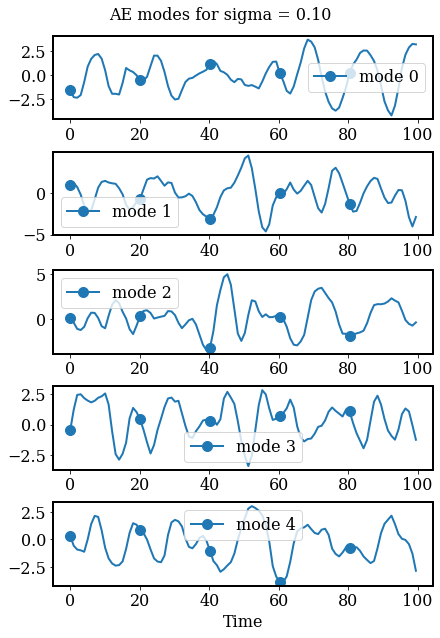

In [19]:
param_num = 0

def select_variable(param_num):
    p_indx = sum(list(Nt_train.values())[:param_num]); 
    encoded = encoded_u[p_indx:p_indx+Nt_train[param_num]]; ldim = latent_dim_u
    return encoded, ldim

def plot_latent_param_nums(param_num):

    num_rows = 5 #np.maximum(4, encoded.shape[1]//4)
    fig, ax = plt.subplots(nrows=num_rows,ncols=1,figsize=(6,num_rows*1.75),constrained_layout=True)    

    for ix,comp in enumerate([param_num]):
        encoded, ldim = select_variable(comp)
        
        for i in range(num_rows):
            tt = ax[i].plot(times_offline[comp][:train_end[comp]+1:snap_incr],encoded[:,i],label='mode %d'%i,marker='o',markevery=20)
            ax[i].legend()
        ax[i].set_xlabel('Time')  
        fig.suptitle('AE modes for %s = %.2f'%(flag, param_train[param_num]),fontsize=16)  


plot_latent_param_nums(param_num)


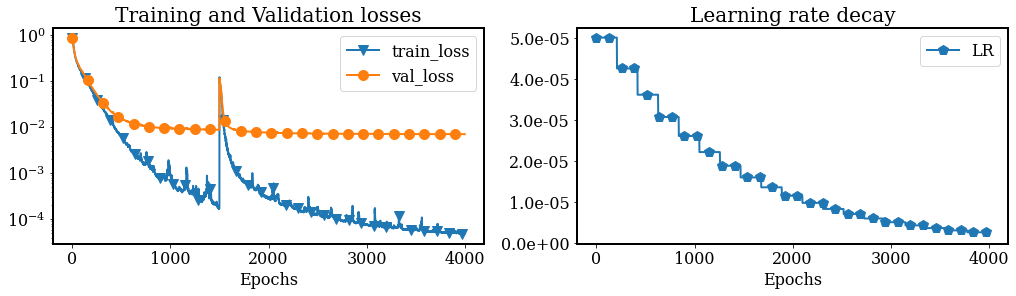

In [20]:
## Visualization losses and learning rate evolution
num_epochs_u = np.arange(epochs_u)

pu.plot_training(num_epochs_u, loss_u, vloss_u, lr_u)



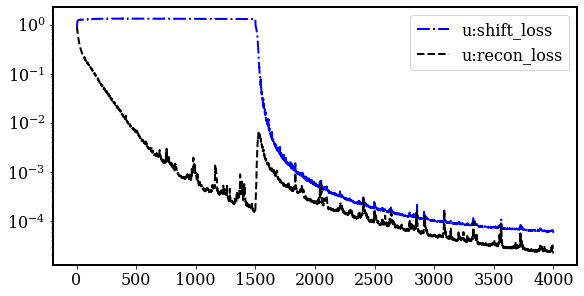

In [21]:
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,4),constrained_layout=True)
ax.semilogy(num_epochs_u, sloss_u,'b-.',label='u:shift_loss')
ax.semilogy(num_epochs_u, rloss_u,'k--',label='u:recon_loss')
ax.legend()


In [22]:
### Predict using all high-fidelity data points 
### for parameter values in the training set

iparam = np.random.choice(len(param_train))
print("Testing AE predictions for %s = %f (parameter number = %d)"%(flag,param_train[iparam], iparam))
val = param_train[iparam]/p_max

u_test = snap_data[iparam][soln_names[0]][:,:snap_end[iparam]+1].T
u_shift_test = shifted_snap[iparam][soln_names[0]][:,:snap_end[iparam]+1].T
if scaling:
    u_test, u_shift_test, _, _ = du.data_scaler(u_test, u_shift_test, u_max, u_min)

u_test = np.hstack((u_test , val*np.ones((Nt[iparam],1)) ))
u_shift_test = np.hstack((u_shift_test , val*np.ones((Nt[iparam],1)) ))



encoded_u_test = u_autoencoder.encoder(u_test).numpy()
if augment_output:
    shift_u_test = u_autoencoder.shift(encoded_u_test).numpy()[:,:-1]
    decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()[:,:-1]
else:
    shift_u_test = u_autoencoder.shift(encoded_u_test).numpy()
    decoded_u_test = u_autoencoder.decoder(encoded_u_test).numpy()

pred_shift = {}
pred_shift[soln_names[0]] = du.scaler_inverse(shift_u_test, u_max, u_min, scaling=scaling).T

pred_recon = {}
pred_recon[soln_names[0]] = du.scaler_inverse(decoded_u_test, u_max, u_min, scaling=scaling).T



Testing AE predictions for sigma = 0.100000 (parameter number = 0)


Text(0.5, 0.98, 'Comparing AE predictions of shifted snapshots \nfor sigma = 0 at t = 1.63 mins')

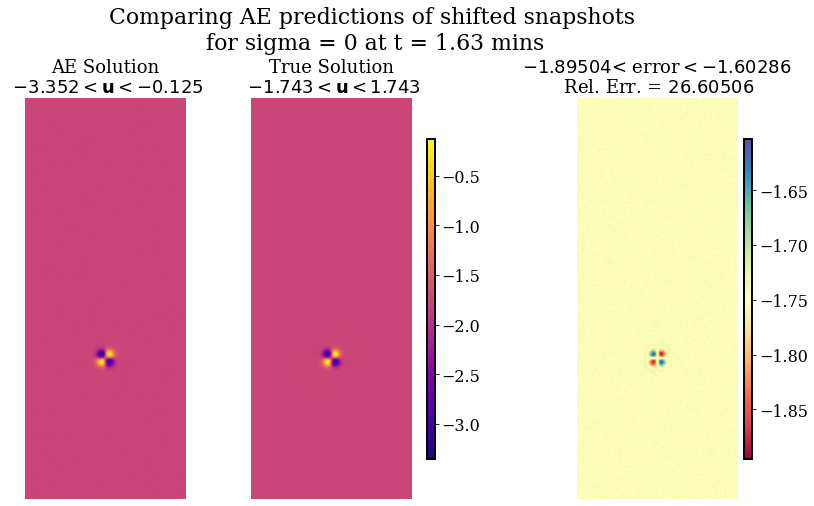

In [23]:
### Visualizing reconstruction of shifted snapshots using shift decoder  
    
fig = plt.figure(figsize=(14,8))
ky = soln_names[0]; 
np.random.seed(2021)
iplot = times_offline[iparam].size-5 
fig.tight_layout()
fig.subplots_adjust(top=0.82)

pu.compare_soln(pred_shift,shifted_snap[iparam],iplot,times_offline[iparam],times_offline[iparam],
                Nx,Ny,ky,flag='AE', cmap=cm.plasma)
fig.suptitle("Comparing AE predictions of shifted snapshots \nfor %s = %d at t = %.2f mins"%(flag, param_train[iparam], times_offline[iparam][iplot]/60),fontsize=22, y=0.98)


Text(0.5, 0.98, 'Comparing AE predictions of true snapshots \nfor sigma = 0 at t = 1.63 mins')

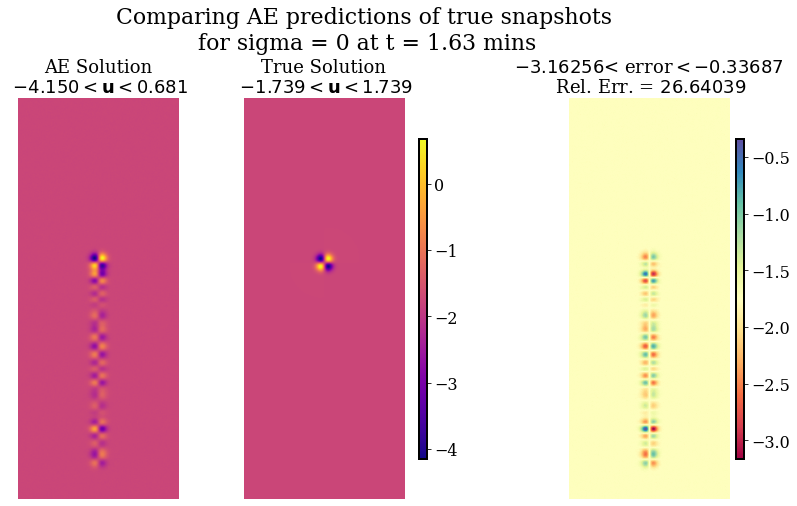

In [24]:
### Visualizing direct reconstruction using true decoder

fig = plt.figure(figsize=(14,8))
fig.tight_layout()
fig.subplots_adjust(top=0.82)

pu.compare_soln(pred_recon,snap_data[iparam],iplot,times_offline[iparam],times_offline[iparam],
                Nx,Ny,ky,flag='AE', cmap=cm.plasma)
fig.suptitle("Comparing AE predictions of true snapshots \nfor %s = %d at t = %.2f mins"%(flag, param_train[iparam], times_offline[iparam][iplot]/60),fontsize=22, y=0.98)



Text(0.5, 0.98, 'Solution along a slice at x = -0.090452 (left) and x = 0.090452 (right)')

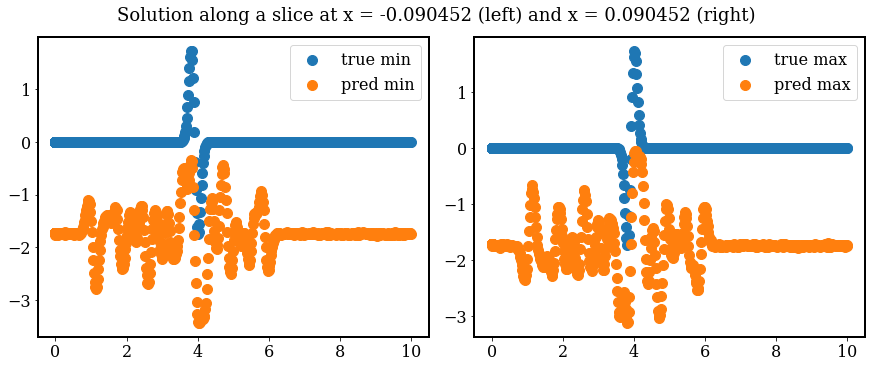

In [25]:
iplot = np.random.choice(decoded_u_test.shape[0])

max_val = snap_data[iparam]['flower'][:,iplot].max()
max_ind = np.where(snap_data[iparam]['flower'][:,iplot] == max_val)

max_x = nodes[max_ind,0]; max_y = nodes[max_ind,1]

min_val = snap_data[iparam]['flower'][:,iplot].min()
min_ind = np.where(snap_data[iparam]['flower'][:,iplot] == min_val)

min_x = nodes[min_ind,0]; min_y = nodes[min_ind,1]

min_x_ind = np.where(nodes[:,0] == min_x)
max_x_ind = np.where(nodes[:,0] == max_x)
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,5),constrained_layout=True)
ax[0].scatter(nodes[min_x_ind,1], snap_data[iparam]['flower'][min_x_ind,iplot], label='true min')
ax[0].scatter(nodes[min_x_ind,1], pred_recon['flower'][min_x_ind,iplot], label='pred min')
ax[0].legend()
ax[1].scatter(nodes[max_x_ind,1], snap_data[iparam]['flower'][max_x_ind,iplot], label='true max')
ax[1].scatter(nodes[max_x_ind,1], pred_recon['flower'][max_x_ind,iplot], label='pred max')
ax[1].legend()
fig.suptitle('Solution along a slice at x = %f (left) and x = %f (right)' %(min_x,max_x), fontsize=18)


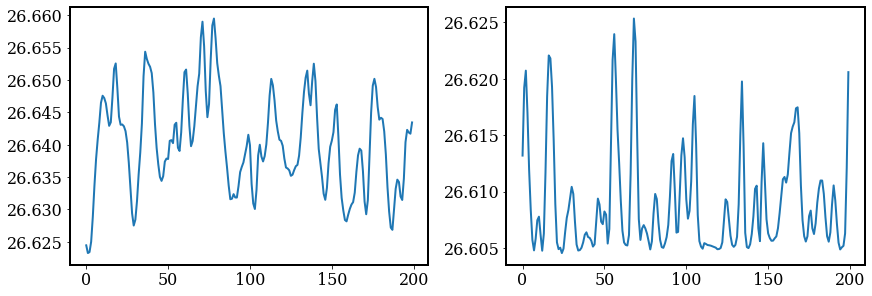

In [26]:
## Compute rel error for decoded prediction of shifted solutions
rel_err_shift = {}
rel_err_recon = {}
key = 'flower'
for iparam,val in enumerate(param_train[:]):
    iparam = param_train.index(val);
    true = shifted_snap[iparam][key][:,:snap_end[iparam]+1]
    true2 = snap_data[iparam][key][:,:snap_end[iparam]+1]
    rel_err_shift[iparam] = np.linalg.norm(pred_shift[key]-true,axis=0)/np.linalg.norm(true,axis=0)
    rel_err_recon[iparam] = np.linalg.norm(pred_recon[key]-true2,axis=0)/np.linalg.norm(true2,axis=0)
    shift_max = np.amax(rel_err_shift[iparam][:-1])
    recon_max = np.amax(rel_err_recon[iparam][:-1])

    
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(12,4),constrained_layout=True)

iparam = len(param_train)-1
ax[0].plot(rel_err_recon[iparam])
ax[1].plot(rel_err_shift[iparam])

In [ ]:
## Evaluate predictions on a dataset with unseen parameter value

new_test = False

if new_test:        

    test_param = np.random.choice(param_test)  
    c_new = 1; sigma_new = test_param
    print("Chosen parameter: %s = %f"%(flag, test_param))
    print("\nLoading pre-computed true snapshots -----")

    new_data = np.load(os.path.join(data_dir,'Gaussian2d_flower_500x200_c0.05_sigma%.4f.npz'%sigma_new))
    snap_new, times_new, nodes2, Nx2, Ny2, snap_start_new, snap_end_new = du.read_data(new_data, soln_names)
    Nt_new = times_new.size

    
    print("\nLoading pre-computed shifted snapshots -----")
    new_shift_data = np.load(os.path.join(data_dir,'ShiftedGaussian2d_flower_500x200_c0.05_sigma%.4f.npz'%sigma_new))
    shifted_snap_new = {}
    for key in soln_names:
#         tmp = new_shift_data[key].reshape((Nn,-1))
        shifted_snap_new[key] = new_shift_data[key].reshape((Nn,-1))

    del new_data
    del new_shift_data
    gc.collect()



    u_new = snap_new[soln_names[0]][:,:snap_end_new+1].T
    u_shift_new = shifted_snap_new[soln_names[0]][:,:snap_end_new+1].T
    if scaling:
        u_new, u_shift_new, _, _ = du.data_scaler(u_new, u_shift_new, u_max, u_min)

    u_new = np.hstack(( u_new, (test_param/p_max)*np.ones((Nt_new,1)) ))
    u_shift_new = np.hstack(( u_shift_new, (test_param/p_max)*np.ones((Nt_new,1)) ))

    
    encoded_u_new = u_autoencoder.encoder(u_new).numpy()
    if augment_output:
        shift_u_new = u_autoencoder.shift(encoded_u_new).numpy()[:,:-1]
        decoded_u_new = u_autoencoder.decoder(encoded_u_new).numpy()[:,:-1]
    else:
        shift_u_new = u_autoencoder.shift(encoded_u_new).numpy()
        decoded_u_new = u_autoencoder.decoder(encoded_u_new).numpy()

    pred_shift_new = {}
    pred_shift_new[soln_names[0]] = du.scaler_inverse(shift_u_new, u_max, u_min, scaling=scaling).T

    pred_recon_new = {}
    pred_recon_new[soln_names[0]] = du.scaler_inverse(decoded_u_new, u_max, u_min, scaling=scaling).T



In [ ]:
### Visualizing reconstruction of shifted snapshots using shift decoder
if new_test:
    fig = plt.figure(figsize=(14,8))
    ky = 'flower'; iplot = times_new.size-5 #20 #np.random.choice(times_new.size)
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    pu.compare_soln(pred_shift_new,shifted_snap_new,iplot,times_new,times_new,
                    Nx,Ny,ky,flag='AE', cmap = cm.plasma)
    fig.suptitle("Comparing AE predictions of shifted snapshots \nfor %s = %.2f at t = %.2f mins"%(flag, test_param, times_new[iplot]/60),fontsize=22, y=0.98)



In [ ]:
### Visualizing direct reconstruction using true decoder
if new_test:
    fig = plt.figure(figsize=(14,8))
    fig.tight_layout()
    fig.subplots_adjust(top=0.82)
    pu.compare_soln(pred_recon_new,snap_new,iplot,times_new,times_new,
                    Nx,Ny,ky,flag='AE', cmap = cm.plasma)
    fig.suptitle("Comparing AE predictions of true snapshots \nfor %s = %.2f at t = %.2f mins"%(flag, test_param, times_new[iplot]/60),fontsize=22, y=0.98)

